In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-05-29 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19), the data behind the dashboard: [Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

It seems that there are currently [data-changes](https://github.com/CSSEGISandData/COVID-19/commit/0cea9b2179306618bd7917798819ebf6608d67de#comments) in progress that cause issues. This is mostly an issue for the US data, so that I comment it out. The US data as used in this notebook **is currently wrong**.

In [5]:
covid19.time_series_19_covid_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71,74


In [6]:
covid19.time_series_19_covid_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188,207,220,228,252,260,310,331,345,397,421,458,468,472,502,558,558,610,648,691,745,745,778,801,850,930,938,996,1040,1075,1097,1128,1138,1209
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403,410,422,431,455,470,488,519,531,543,570,595,605,620,627,650,654,682,688,694,705,714,715,727,742,758,771,777,783,789,795,803,812,823
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651,1702,1779,1821,1872,1936,1998,2067,2197,2323,2467,2546,2678,2841,2998,3058,3158,3271,3409,3507,3625,3746,3968,4062,4256,4426,4784,4747,4918,5129,5277
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344,344,385,398,423,468,468,472,493,499,514,521,526,537,545,550,550,568,576,596,604,615,617,624,628,639,639,652,653,653,663,676,676,681
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,7,7,11,11,11,11,11,11,11,11,13,13,13,13,14,14,17,17,17,17,17,17,17,17,18,18,18,18,18,18


In [7]:
df = covid19.get_cases_by_region(region='China')
df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,84095,79343,4638,11,8,0
2020-05-25,84102,79352,4638,7,9,0
2020-05-26,84103,79358,4638,1,6,0
2020-05-27,84106,79367,4638,3,9,0
2020-05-28,84106,79371,4638,0,4,0


* [BAR CHART ANNOTATIONS WITH PANDAS AND MATPLOTLIB](https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html)

In [8]:
df = covid19.get_rki_df()
cbr_germany = covid19.CasesByRegion('Germany', df=df)
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-24,179038,163927,8280,223,0,21
2020-05-25,179326,163927,8308,288,0,28
2020-05-26,179762,163924,8369,436,-3,61
2020-05-27,180113,163924,8429,351,0,60
2020-05-28,180292,163924,8467,179,0,38


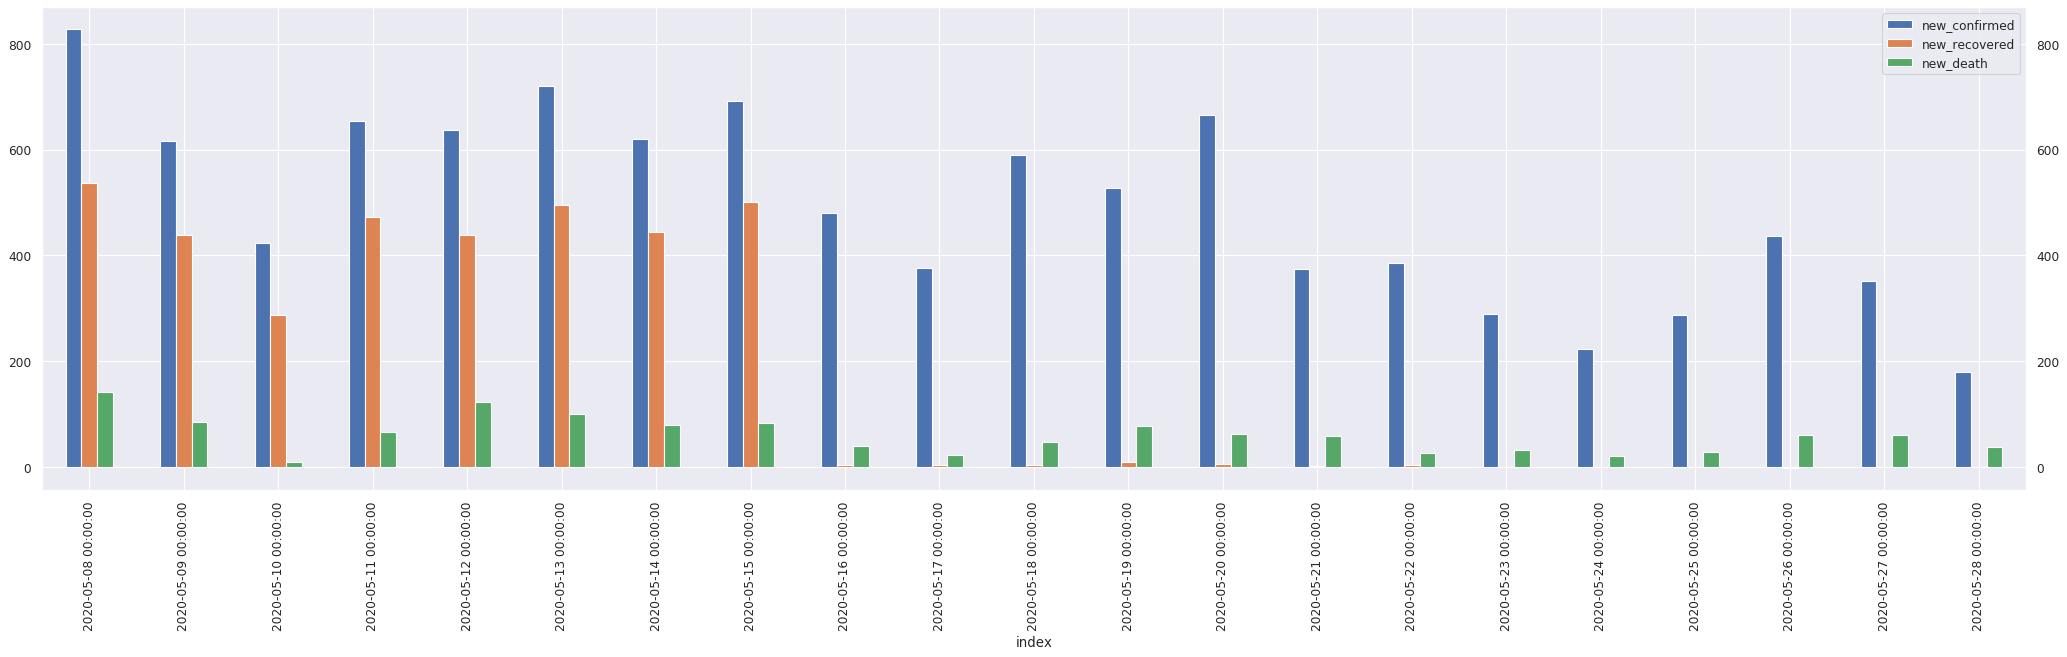

In [9]:
cbr_germany.plot_daily_stats()

[COVID-19-Pandemie#Deutschland](https://de.wikipedia.org/wiki/COVID-19-Pandemie#Deutschland):

> Am 22. März 2020 einigten sich Bund und Länder auf ein „umfassendes Kontaktverbot“, statt weitergehende Ausgangssperren zu beschließen.


> Roughly 2020-04-21 the taken actions show clear effect; roughly 4.5 weeks later.

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate  | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-21 |  92845 | 0.057 | - |
| 2020-04-03 | 2020-04-23 |  99774 | 0.054 | - |
| 2020-04-04 | 2020-04-25 | 107193 | 0.051 | - |
| 2020-04-05 | 2020-04-27 | 114511 | 0.049 | - |
| 2020-04-06 | 2020-04-29 | 119618 | 0.045 | - |
| 2020-04-07 | 2020-04-29 | 121354 | 0.039 | - |
| 2020-04-08 | 2020-04-30 | 123011 | 0.035 | - |
| 2020-04-09 | 2020-04-30 | 125833 | 0.031 | - |
| 2020-04-10 | - | - | 0.049 | 4820 |
| 2020-04-11 | - | - | 0.042 | 4739 |
| 2020-04-12 | - | - | 0.040 | 4570 |
| 2020-04-13 | - | - | 0.036 | 4300 |
| 2020-04-14 | - | - | 0.033 | 3927 |
| 2020-04-15 | - | - | 0.029 | 3451 |
| 2020-04-16 | - | - | 0.026 | 3086 |
| 2020-04-17 | - | - | 0.024 | 2845 |
| 2020-04-19 | - | - | 0.021 | 2666 |
| 2020-04-20 | - | - | 0.020 | 2554 |
| 2020-04-21 | - | - | 0.018 | 2356 |
| 2020-04-24 | - | - | 0.015 | 2043 |
| 2020-04-25 | 2020-05-24 | 166654 | 0.011 | - |
| 2020-04-26 | 2020-05-26 | 167739 | 0.010 | - |
| 2020-04-27 | 2020-05-26 | 168771 | 0.009 | - |
| 2020-04-28 | - | - | 0.013 | 1538 |
| 2020-04-29 | 2020-05-25 | 169856 | 0.008 | - |
| 2020-04-30 | 2020-05-26 | 170081 | 0.007 | - |
| 2020-05-01 | 2020-06-06 | 176154 | 0.007 | - |
| 2020-05-02 | 2020-06-06 | 176278 | 0.006 | - |
| 2020-05-03 | 2020-06-06 | 176466 | 0.006 | - |
| 2020-05-04 | 2020-06-06 | 176419 | 0.005 | - |
| 2020-05-09 | 2020-06-07 | 177511 | 0.004 | - |
| 2020-05-11 | 2020-06-07 | 177421 | 0.003 | - |
| 2020-05-12 | 2020-06-07 | 177954 | 0.003 | - |
| 2020-05-17 | 2020-06-08 | 179372 | 0.002 | - |
| 2020-05-24 | 2020-06-09 | 180945 | 0.002 | - |
| 2020-05-28 | 2020-06-10 | 180990 | 0.001 | - |
| 2020-05-29 | - | - | 0.002 | 164 |

In [10]:
cbr_germany.fit(first_date=pd.to_datetime('2020-03-09'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


In [11]:
# cbr_germany.fit_df0.loc[pd.to_datetime('2020-05-24')]

sigmoid+asymmetric+linear: seor: 397.7577176479681; growth-rate: 0.002, date:2020-07-06 00:00:00, projected value: 163.6641023847719


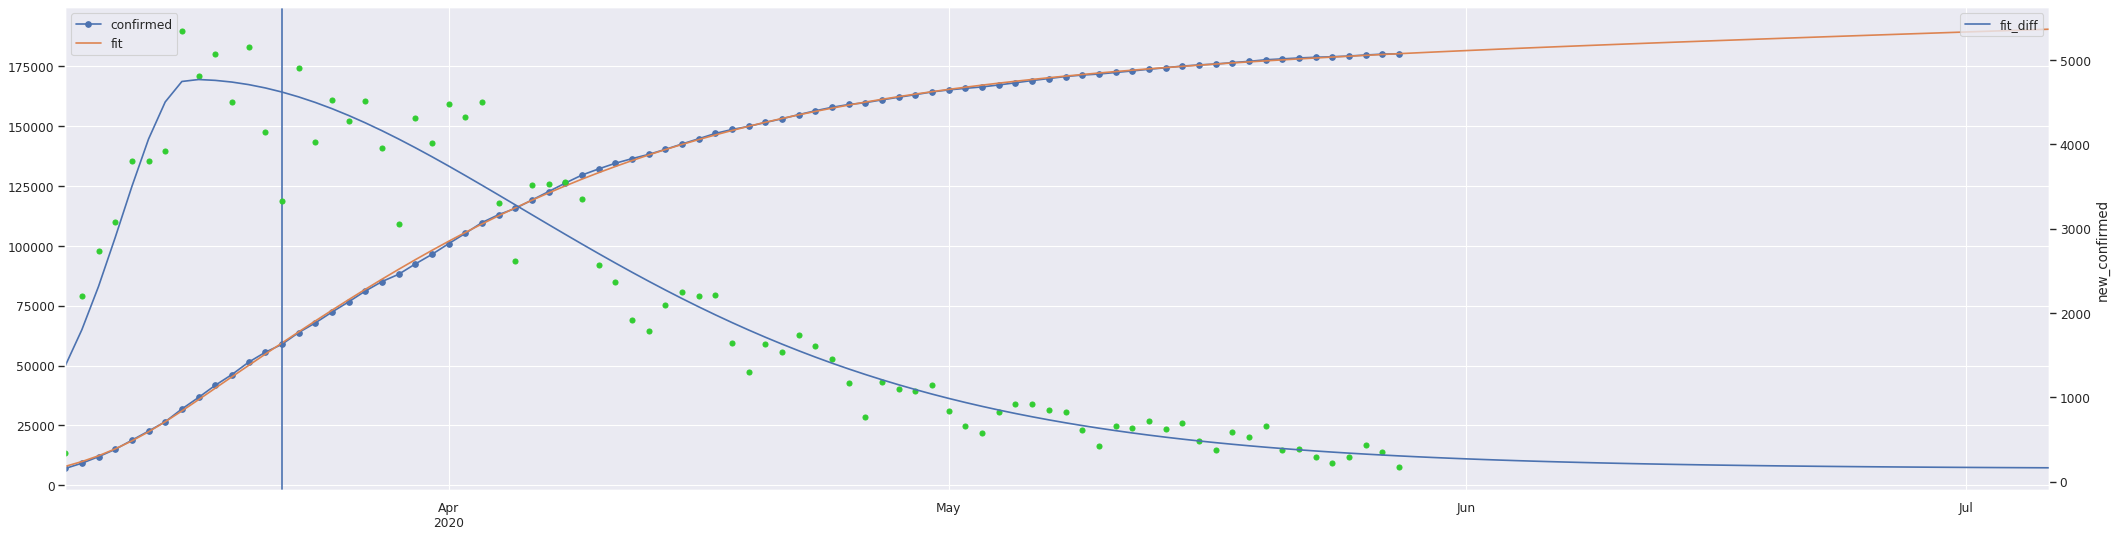

In [12]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 22))

In [13]:
cbr_germany.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4767.031661


In [14]:
cbr_germany.calculate_R_estimates()
cbr_germany.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-26,0.739,0.655,0.654,0.609,0.668


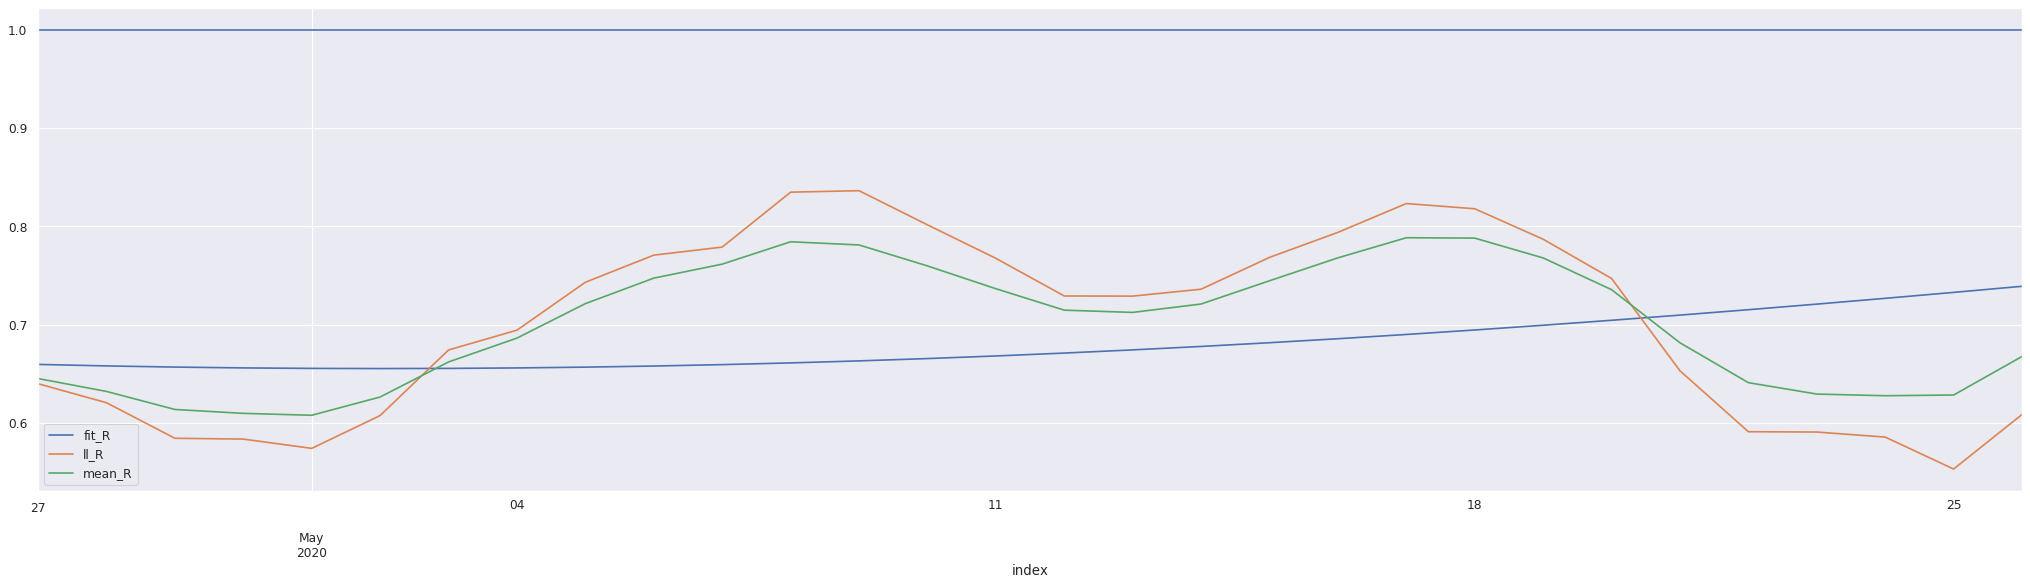

In [15]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_germany.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [16]:
df = covid19.get_austria_df()
cbr_austria = covid19.CasesByRegion('Austria', df=df)
cbr_austria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-24,16470,15063,607,17,26,1
2020-05-25,16509,15138,611,39,75,4
2020-05-26,16538,15182,624,29,44,13
2020-05-27,16584,15228,638,46,46,14
2020-05-28,16598,15286,638,14,58,0


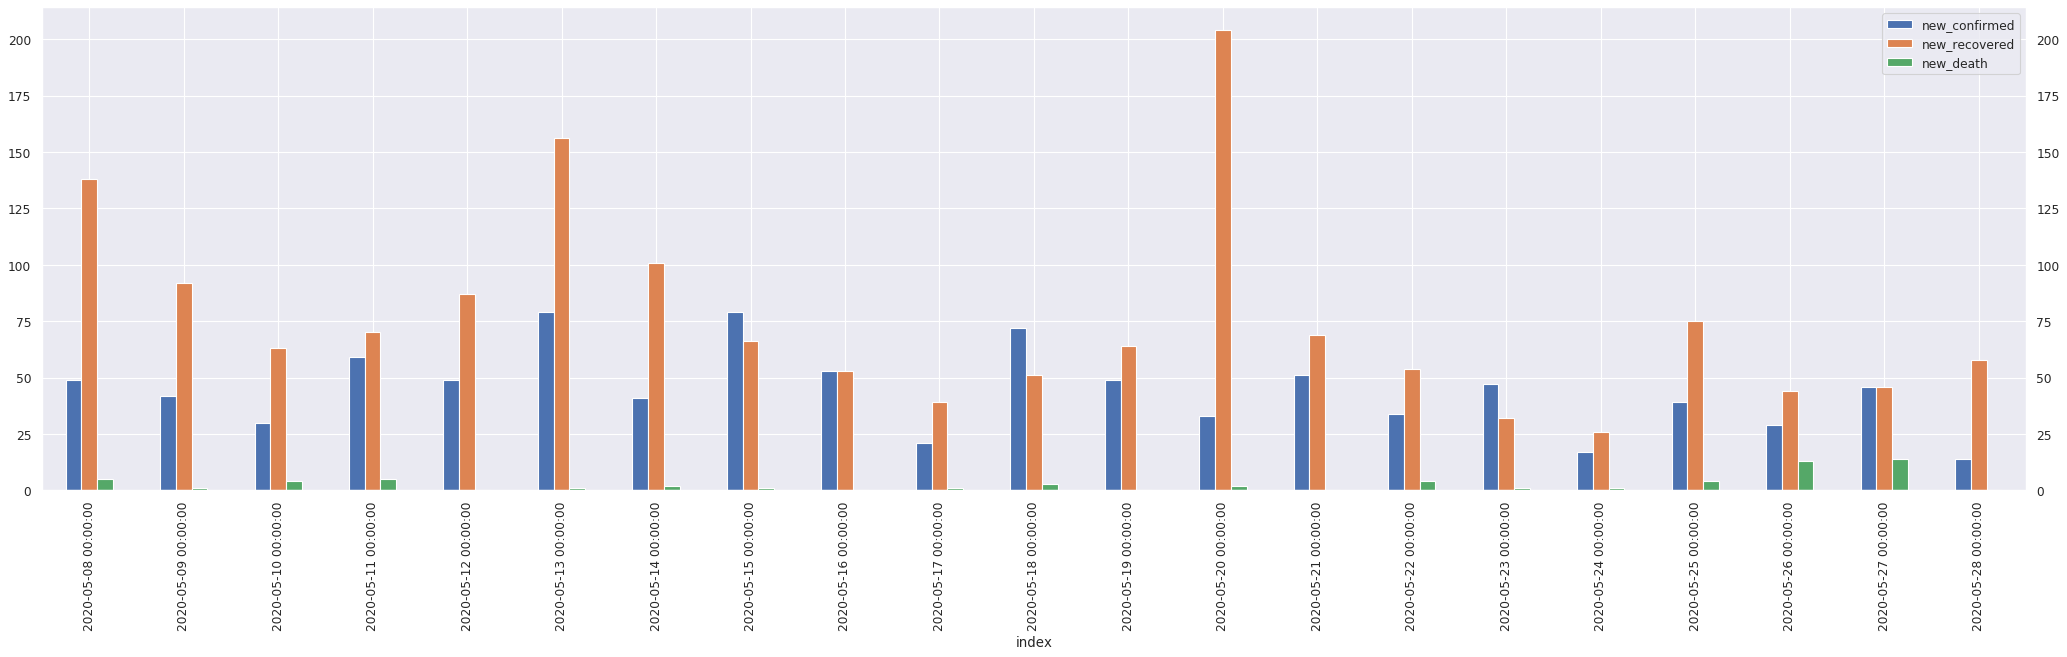

In [17]:
cbr_austria.plot_daily_stats()

[COVID-19-Pandemie#%C3%96sterreich](https://de.wikipedia.org/wiki/COVID-19-Pandemie#%C3%96sterreich)

> Nachdem Mitte März zuerst einzelne Gemeinden unter Quarantäne gestellt wurden, verlautbarte Bundeskanzler Sebastian Kurz am 15. März eine landesweite Ausgangsbeschränkung, verbunden mit einer Einschränkung der Versammlungsfreiheit auf bis zu fünf Personen.

`2020-03-15`

| prediction date | predicted day for reaching 100 threshold | predicted max | growth rate | steady state rate  |
| :--- | :--- | ---: | ---: | ---: |
| 2020-04-02 | 2020-04-12 | 13859 | 0.042 | - |
| 2020-04-03 | 2020-04-12 | 13864 | 0.036 | - |
| 2020-04-04 | 2020-04-12 | 14082 | 0.030 | - |
| 2020-04-05 | 2020-04-12 | 13978 | 0.025 | - |
| 2020-04-06 | 2020-04-11 | 13947 | 0.020 | - |
| 2020-04-07 | 2020-04-12 | 14033 | 0.017 | - |
| 2020-04-08 | 2020-04-12 | 14121 | 0.014 | - |
| 2020-04-09 | 2020-04-12 | 14229 | 0.012 | - |
| 2020-04-10 | 2020-04-12 | 14350 | 0.010 | - |
| 2020-04-11 | 2020-04-13 | 14488 | 0.009 | - |
| 2020-04-12 | - | - | 0.012 | 106 |
| 2020-04-13 | - | - | 0.012 | 123 |
| 2020-04-14 | - | - | 0.011 | 126 |
| 2020-04-15 | - | - | 0.010 | 114 |
| 2020-04-15 | - | - | 0.009 | 107 |
| 2020-04-17 | - | - | 0.009 | 106 |
| 2020-04-19 | - | - | 0.007 |  95 |
| 2020-04-20 | - | - | 0.007 |  87 |
| 2020-04-21 | - | - | 0.006 |  83 |
| 2020-04-24 | - | - | 0.005 |  68 |
| 2020-04-26 | 2020-05-01 | 15208 | 0.002 |  - |
| 2020-04-27 | 2020-05-01 | 15096 | 0.002 |  - |
| 2020-04-28 | 2020-05-01 | 15129 | 0.002 |  - |
| 2020-04-29 | - | - | 0.005 |  84 |
| 2020-04-30 | - | - | 0.005 |  81 |
| 2020-05-01 | - | - | 0.005 |  77 |
| 2020-05-02 | - | - | 0.005 |  76 |
| 2020-05-02 | - | - | 0.004 |  75 |
| 2020-05-04 | - | - | 0.004 |  73 |
| 2020-05-09 | - | - | 0.003 |  60 |
| 2020-05-11 | - | - | 0.003 |  58 |
| 2020-05-12 | - | - | 0.003 |  57 |
| 2020-05-17 | - | - | 0.003 |  55 |
| 2020-05-24 | - | - | 0.003 |  54 |
| 2020-05-29 | - | - | 0.003 |  51 |

In [18]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland
einwohner_österreich  =  8793370.0
prozent_österreich    = einwohner_österreich / einwohner_deutschland

austria_new_confirmed_threshold = (100.0 * prozent_österreich) // 1 + 1
austria_new_confirmed_threshold

11.0

In [19]:
cbr_austria.fit(first_date=pd.to_datetime('2020-03-09'), new_confirmed_threshold=austria_new_confirmed_threshold)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric+linear: seor: 70.87785787060884; growth-rate: 0.003, date:2020-07-06 00:00:00, projected value: 51.239292615201805


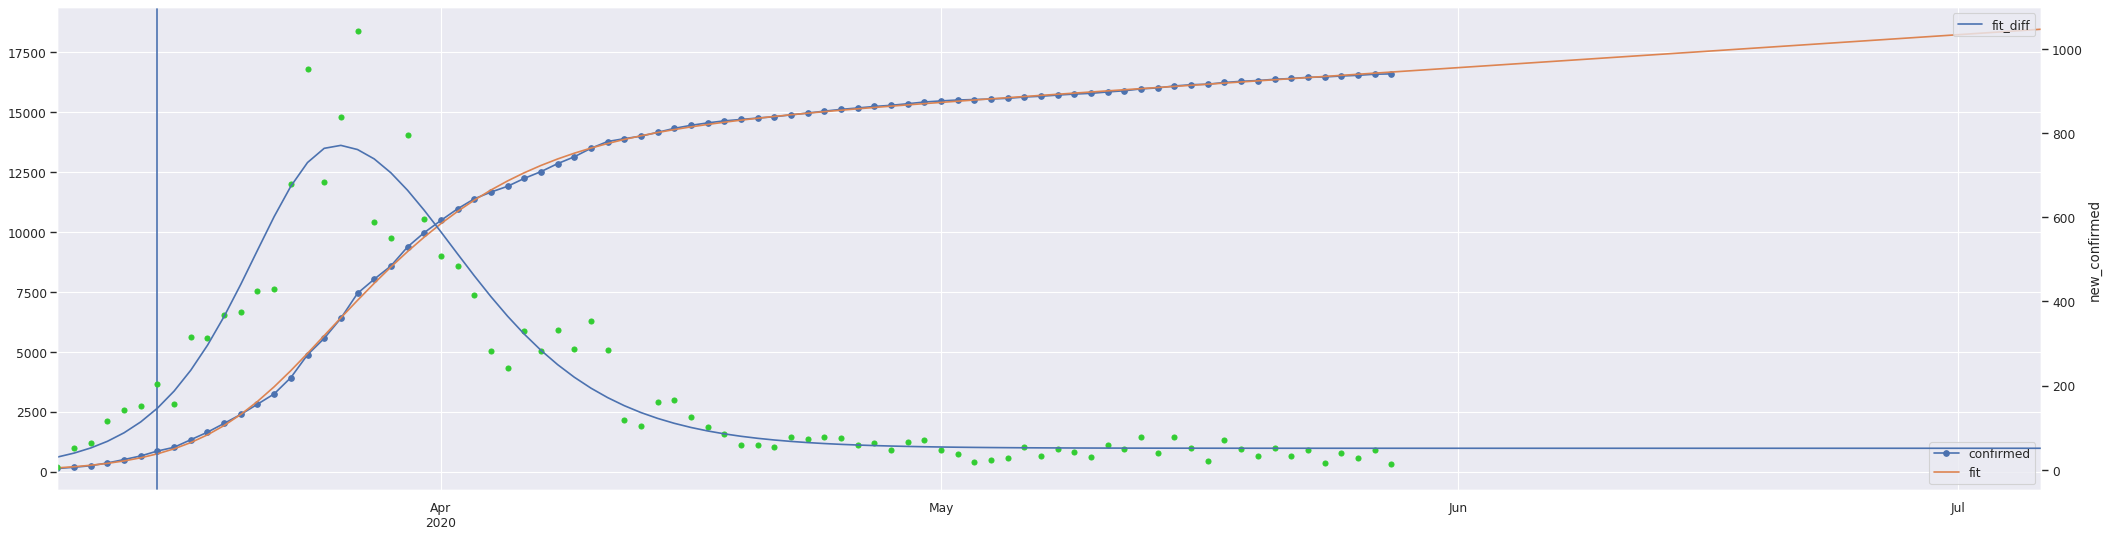

In [20]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 15))

In [21]:
cbr_austria.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,770.822031


In [22]:
cbr_austria.calculate_R_estimates()
cbr_austria.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-26,0.999,0.538,0.432,0.483,0.673


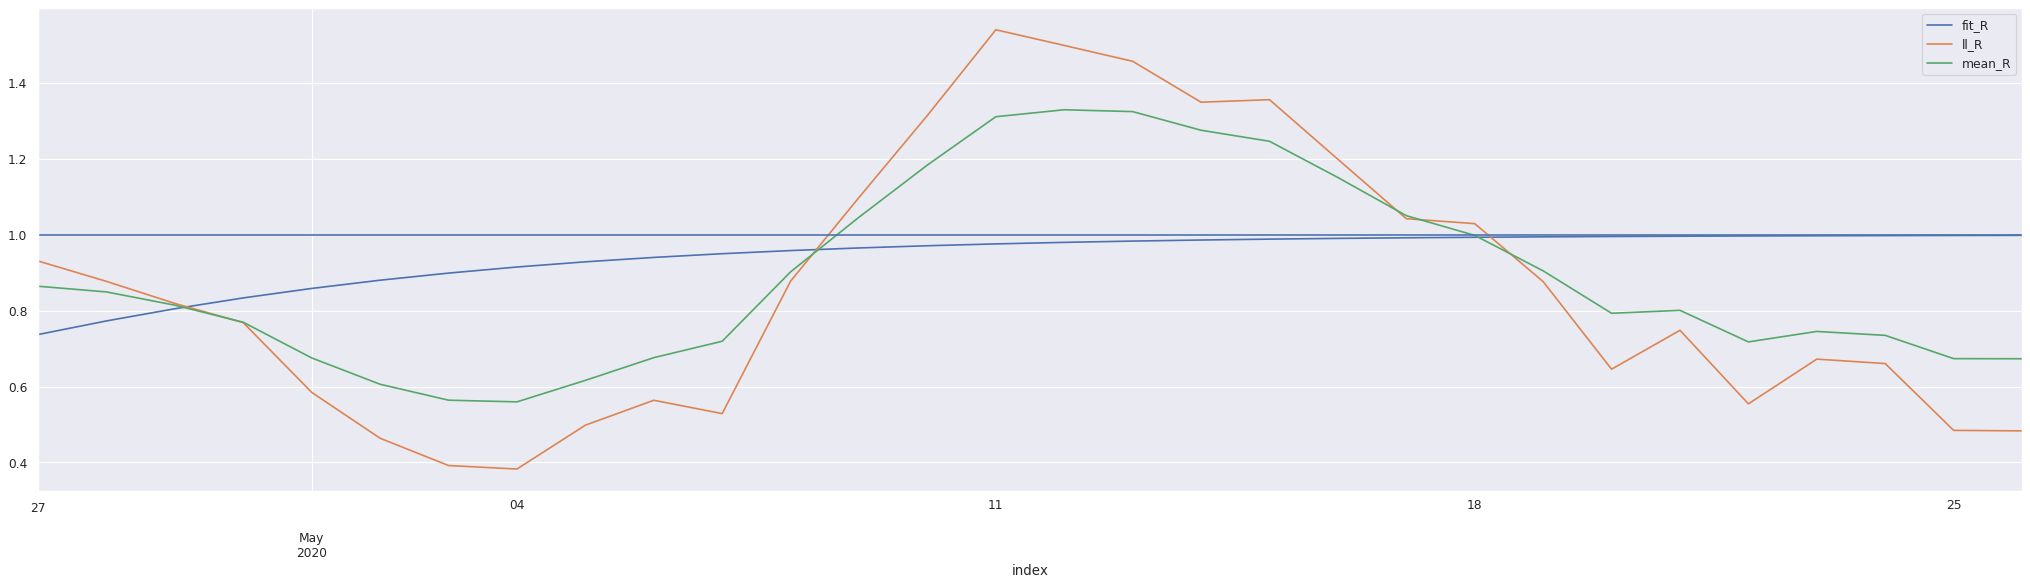

In [23]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_austria.plot_R(ax=ax) # , plot_start_date='2020-03-10'

[COVID-19-Pandemie#Dänemark](https://de.wikipedia.org/wiki/COVID-19-Pandemie#D%C3%A4nemark)

> Dänemark hat besonders früh mit strikten Maßnahmen auf die Corona-Krise reagiert, unter anderem sind seit dem 14. März die Grenzen für Ausländer ohne triftigen Einreisegrund geschlossen.

`2020-03-14`

In [24]:
cbr_denmark = covid19.CasesByRegion('Denmark')
cbr_denmark.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,11559,10098,562,72,64,1
2020-05-25,11586,10162,563,27,64,1
2020-05-26,11627,10242,563,41,80,0
2020-05-27,11680,10304,565,53,62,2
2020-05-28,11712,10378,568,32,74,3


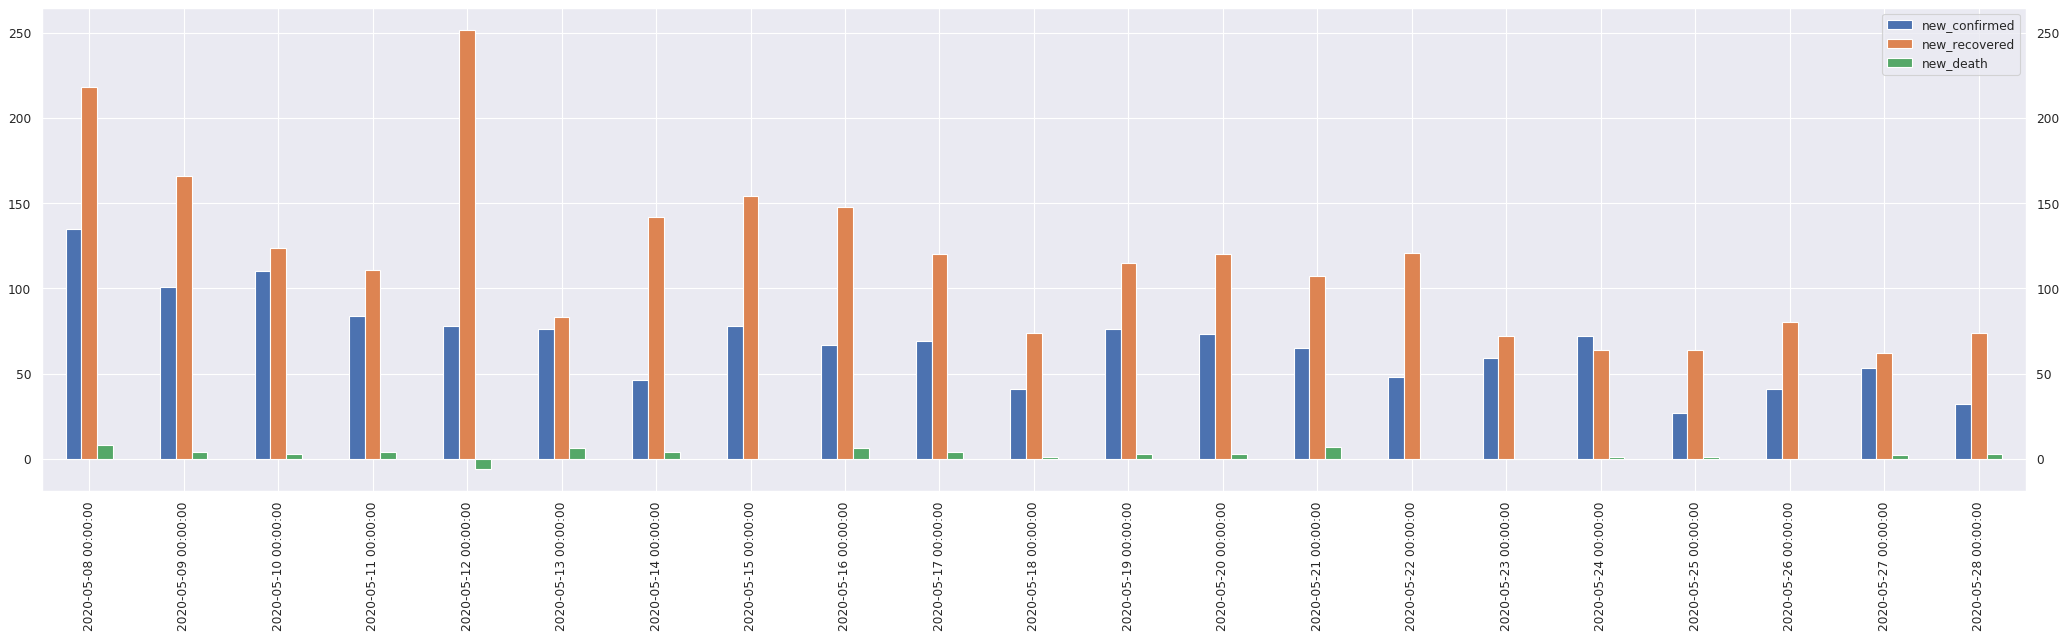

In [25]:
cbr_denmark.plot_daily_stats()

8.0


 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 40.57036254834095; growth-rate: 0.006, date:2020-07-06 00:00:00, projected value: 60.94078928996526


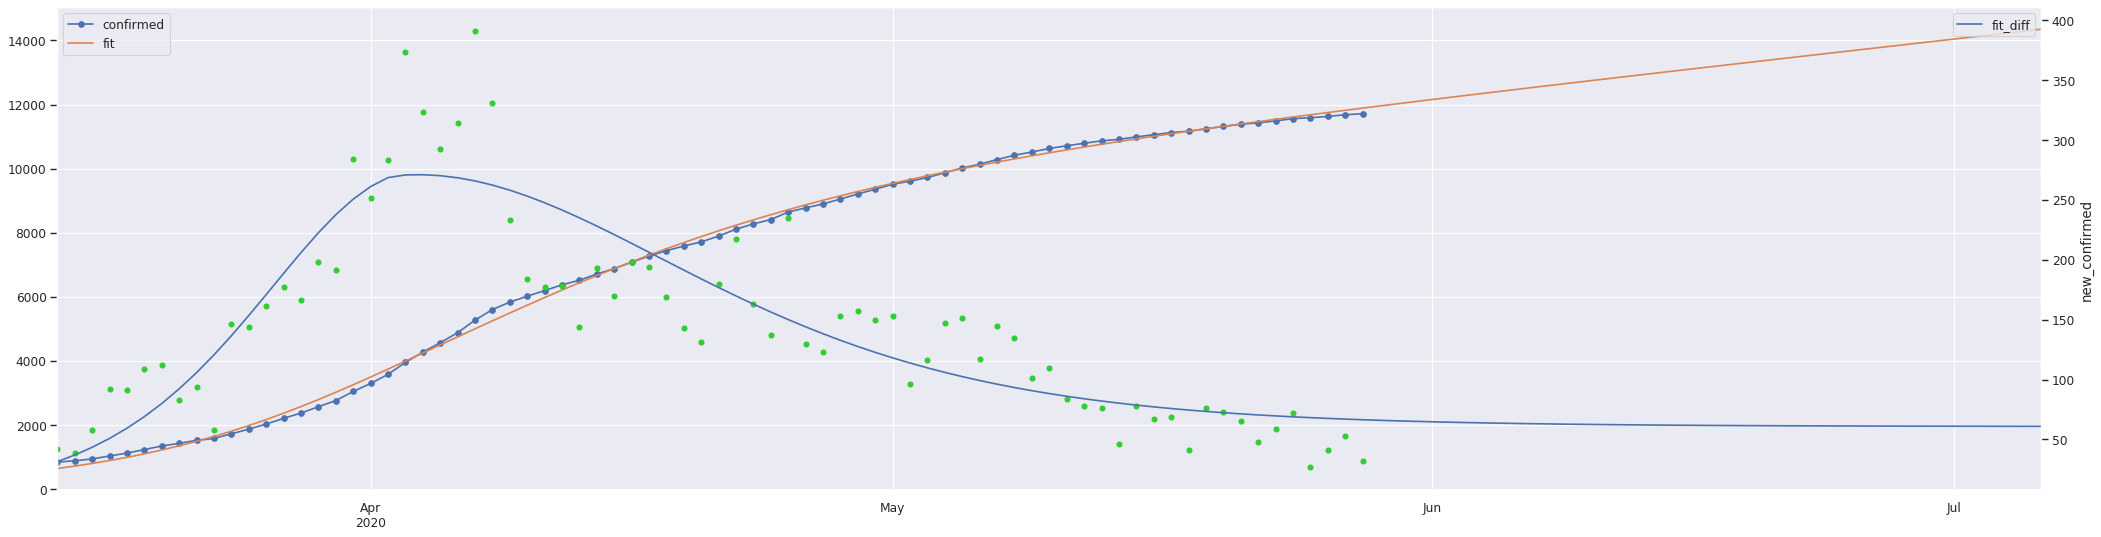

In [26]:
population_denmark  =  5822763.0
percent_denmark     = population_denmark / einwohner_deutschland

denmark_new_confirmed_threshold = (100.0 * percent_denmark) // 1 + 1
print(denmark_new_confirmed_threshold)

# first_date=pd.to_datetime('2020-03-09')
# first_date=pd.to_datetime('2020-03-14')
cbr_denmark.fit(first_date=pd.to_datetime('2020-03-14'), new_confirmed_threshold=denmark_new_confirmed_threshold)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [27]:
cbr_denmark.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,270.83236


In [28]:
cbr_denmark.calculate_R_estimates()
cbr_denmark.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-26,0.917,0.78,0.534,0.721,0.806


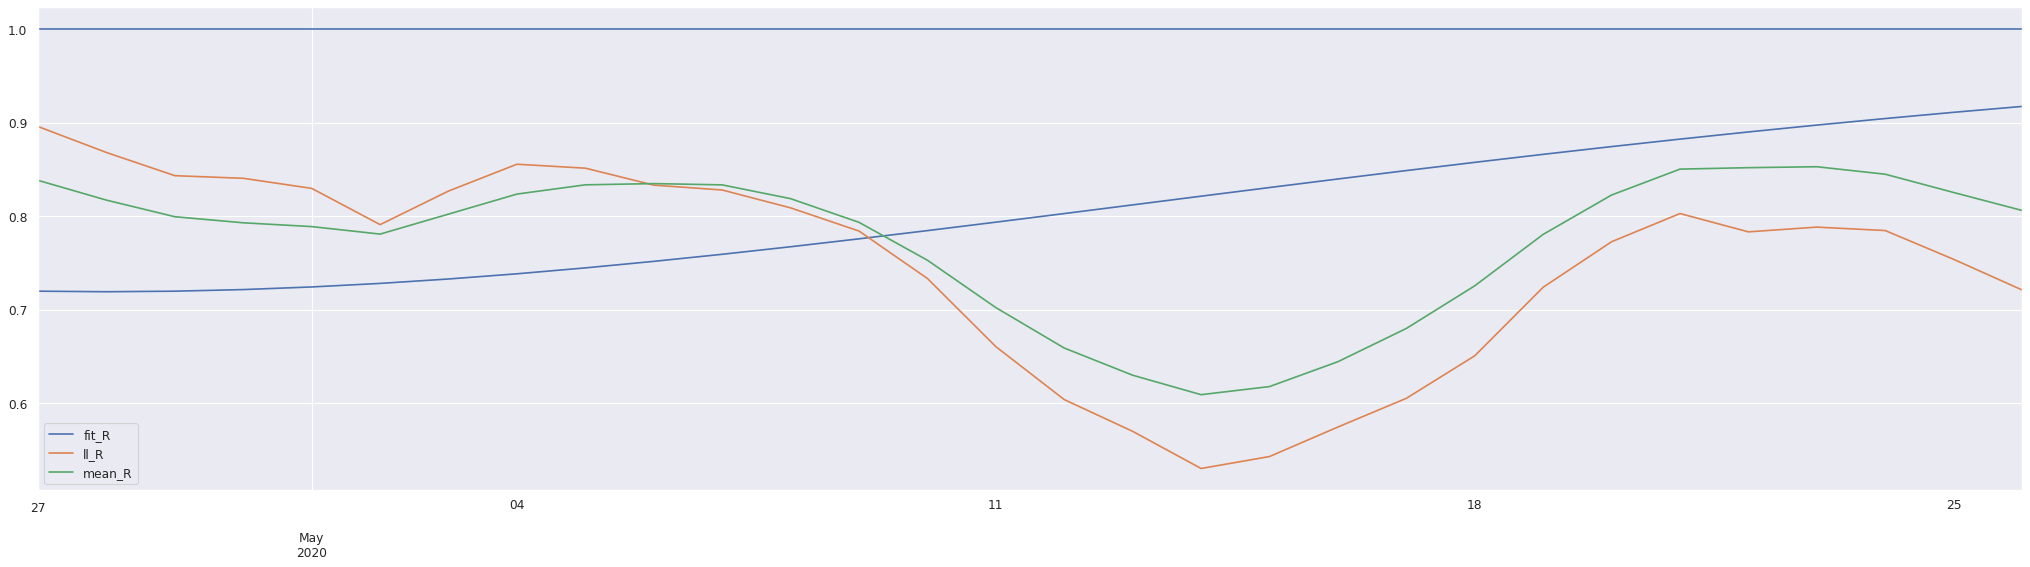

In [29]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_denmark.plot_R(ax=ax) # , plot_start_date='2020-03-10'

There are several data issues since 2020-03-12/2020-03-13 in the input data as pointed out here: [Italy has the same number of cases today as they did yesterday.](https://github.com/CSSEGISandData/COVID-19/issues/599)

Also trying to get the raw numbers that [Coronavirus-Monitor](https://interaktiv.morgenpost.de/corona-virus-karte-infektionen-deutschland-weltweit/?fbclid=IwAR04HlqzakGaNssQzbz4d8o8R3gz0C910U8tvfYlBT6P0lVJJvHfk9uS2rc) is using for Germany from [@datentaeterin](https://twitter.com/datentaeterin/status/1237807179815686144). These numbers seem to be more up-to-date than all the other data-sources.

In [30]:
df = covid19.get_italy_df()
cbr_italy = covid19.CasesByRegion('Italy', df=df)
cbr_italy.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
data,,,,,,
2020-05-24,229858,140479,32785,531,1639,50
2020-05-25,230158,141981,32877,300,1502,92
2020-05-26,230555,144658,32955,397,2677,78
2020-05-27,231139,147101,33072,584,2443,117
2020-05-28,231732,150604,33142,593,3503,70


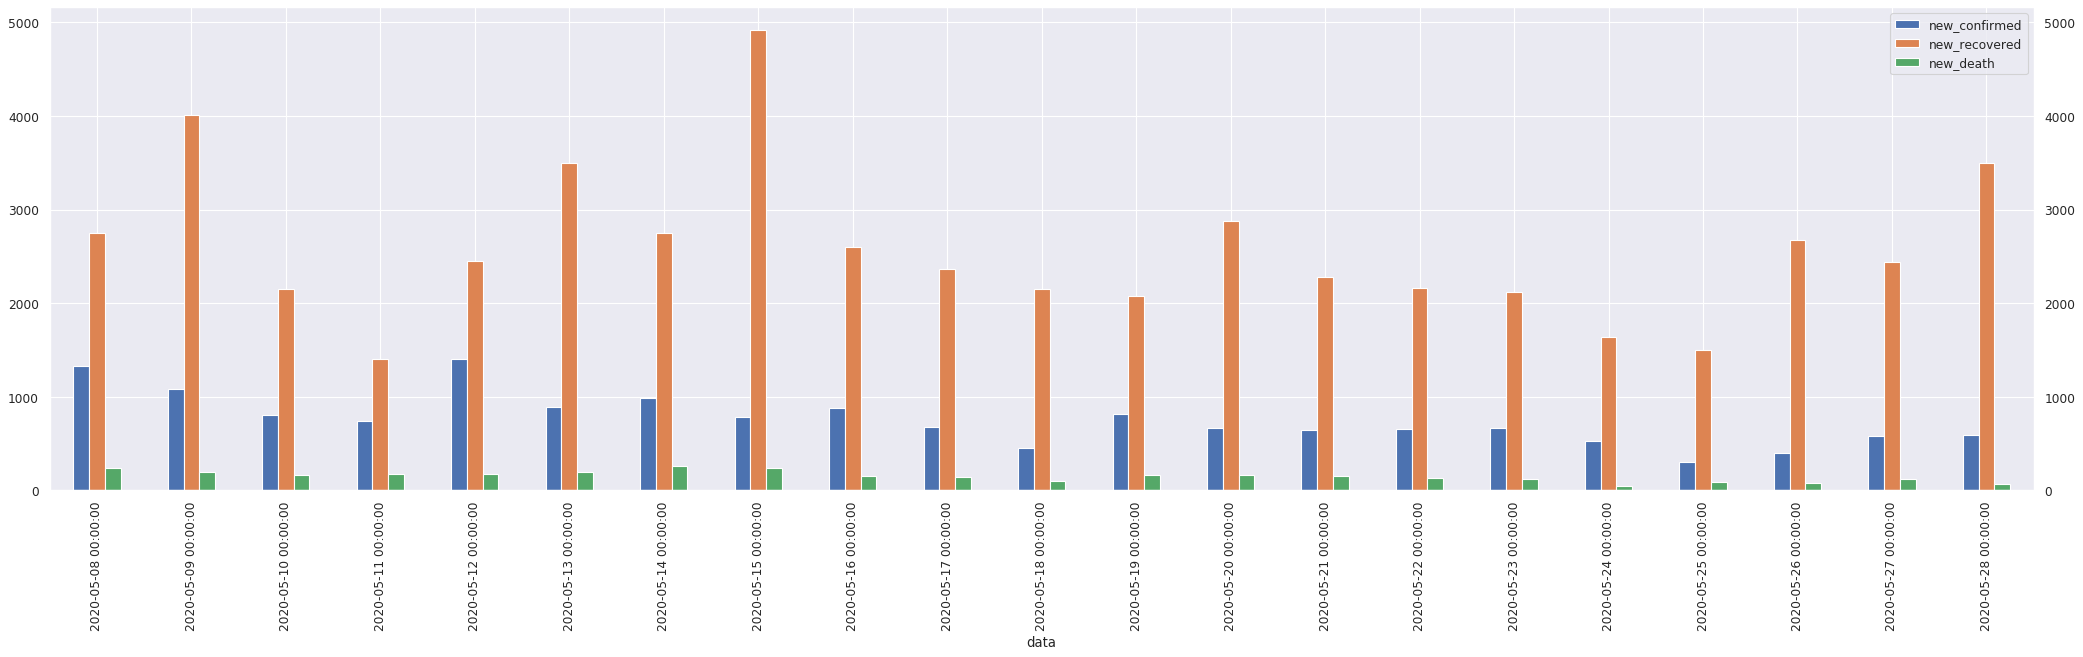

In [31]:
cbr_italy.plot_daily_stats()

In [32]:
cbr_italy.fit(first_date=pd.to_datetime('2020-02-21'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric: seor: 431.4424654468238, max asymptotic: 240009.4889450033; growth-rate: 0.002, date:2020-06-24 00:00:00, projected value: 92.09730623980562


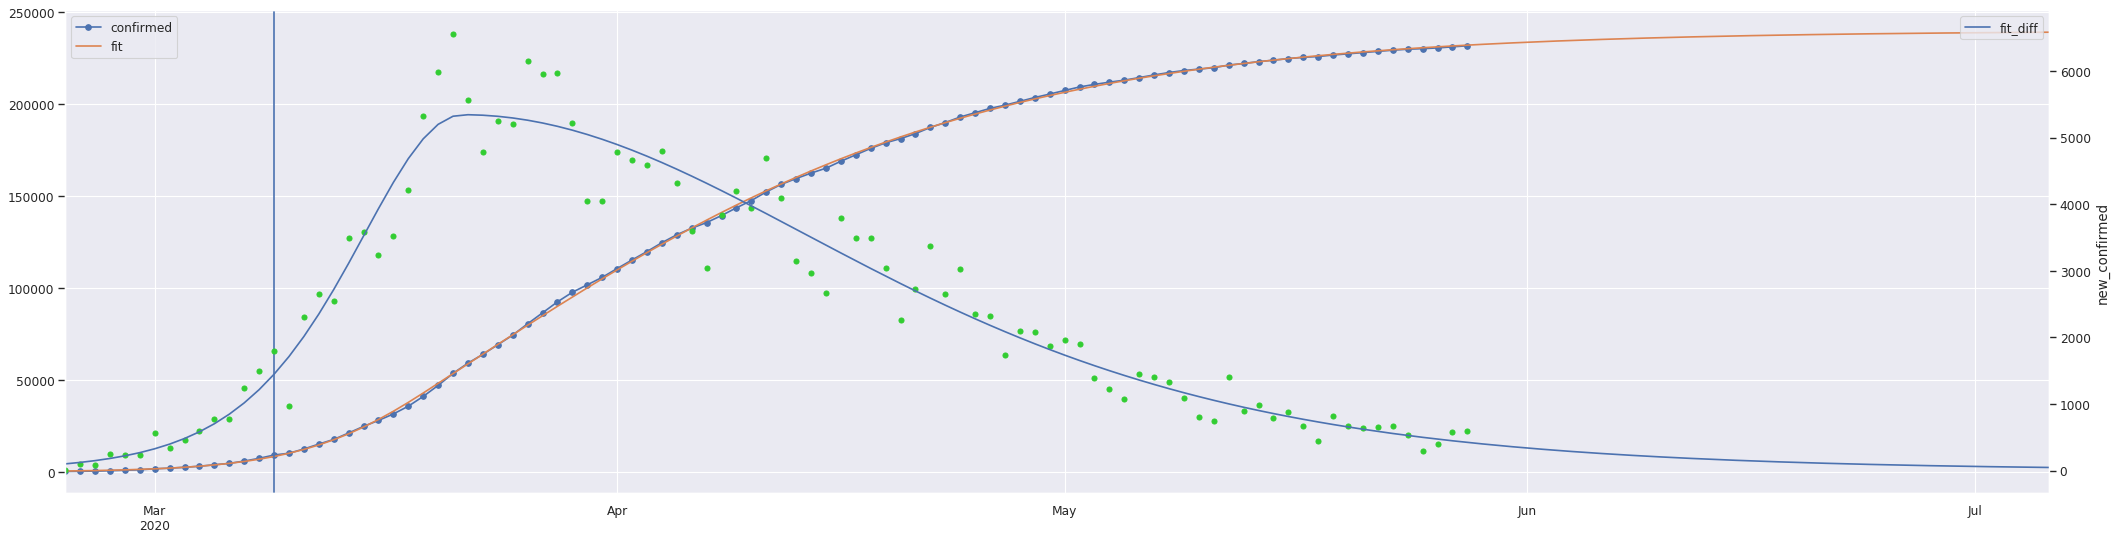

In [33]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 9))

In [34]:
cbr_italy.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5344.678349


In [35]:
cbr_italy.calculate_R_estimates()
cbr_italy.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:Maximum Likelihood optimization failed to converge. Check mle_retvals


,fit_R,gp_R,kf_R,ll_R,mean_R
data,,,,,
2020-05-26,0.629,0.632,0.382,0.568,0.61


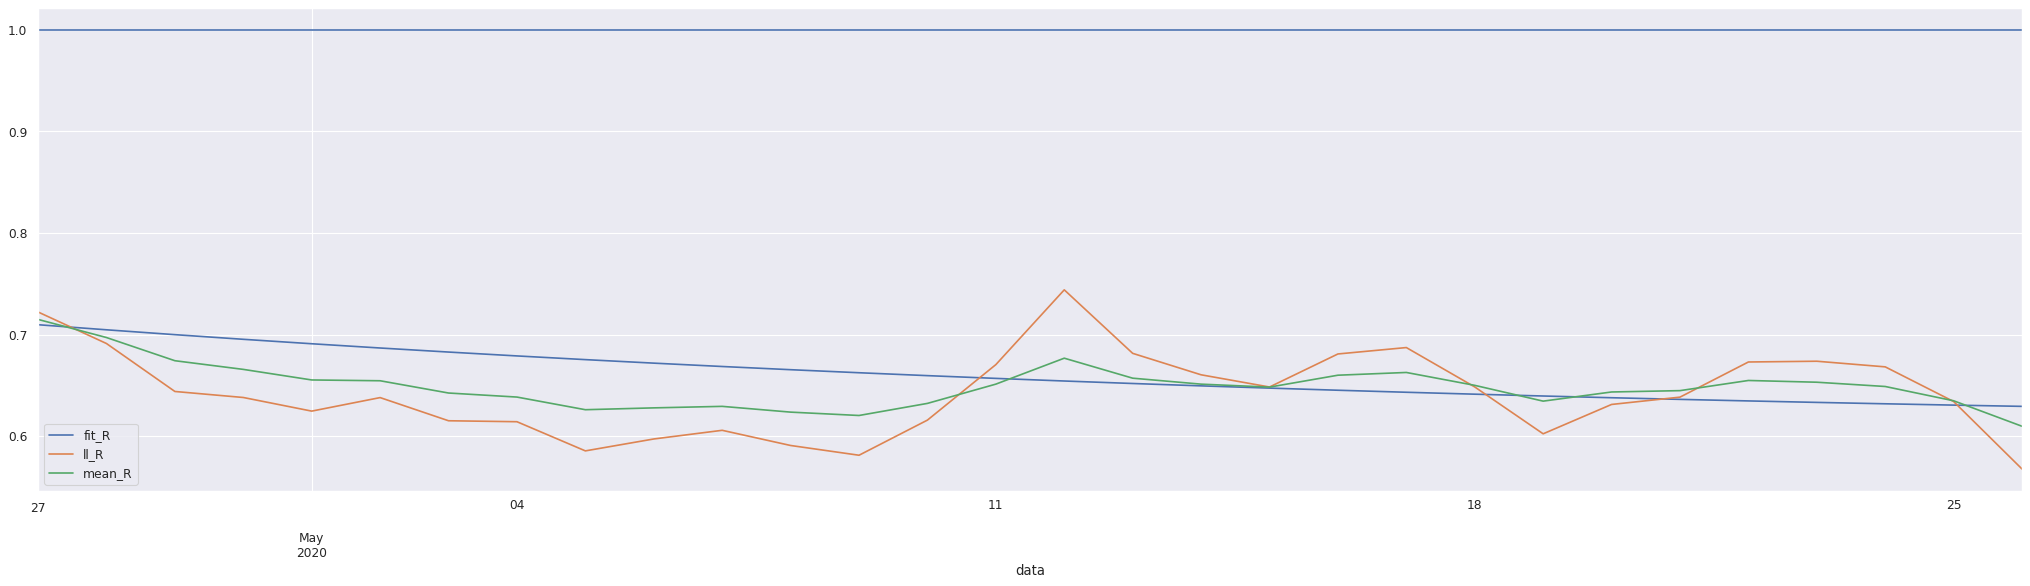

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_italy.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)


* [mscbs.gob.es](https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm)
* https://covid19.isciii.es/
* [github/datadista](https://github.com/datadista/datasets/tree/master/COVID%2019)

In [37]:
df = covid19.get_spain_df()
cbr_spain = covid19.CasesByRegion('Spain', df=df)
cbr_spain.tail()

read csv


,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-05-24,235772,150376,28752,482,0,74
2020-05-25,235400,150376,26834,-372,0,-1918
2020-05-26,236259,150376,27117,859,0,283
2020-05-27,236769,150376,27118,510,0,1
2020-05-28,237906,150376,27119,1137,0,1


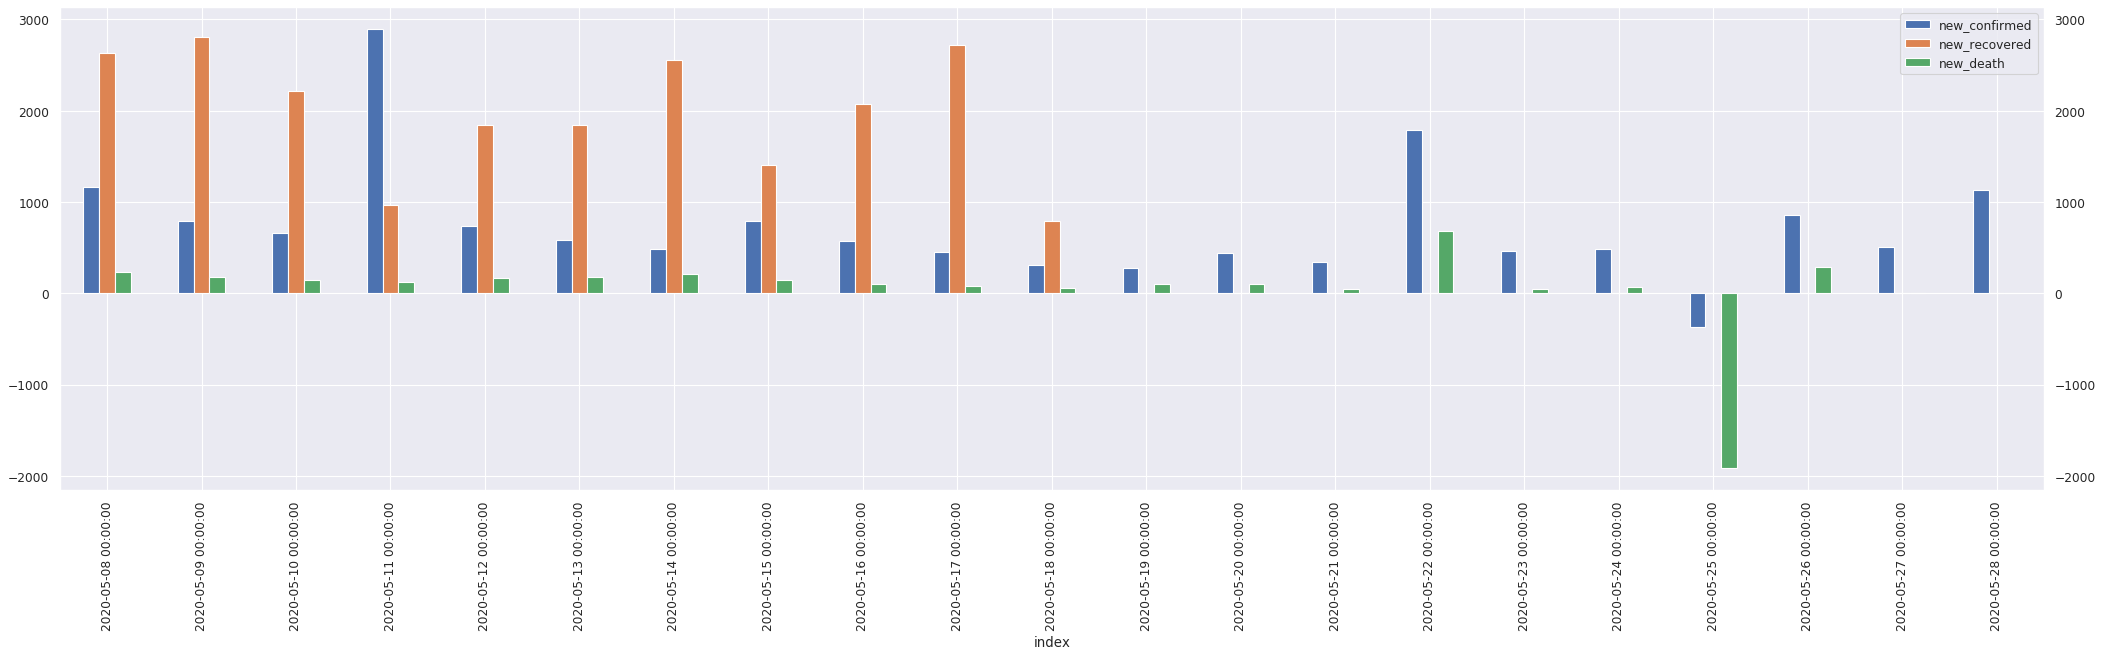

In [38]:
cbr_spain.plot_daily_stats()

In [39]:
cbr_spain.fit(first_date=pd.to_datetime('2020-03-04'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric+linear: seor: 787.8319997565926; growth-rate: 0.003, date:2020-07-06 00:00:00, projected value: 609.8652733049606


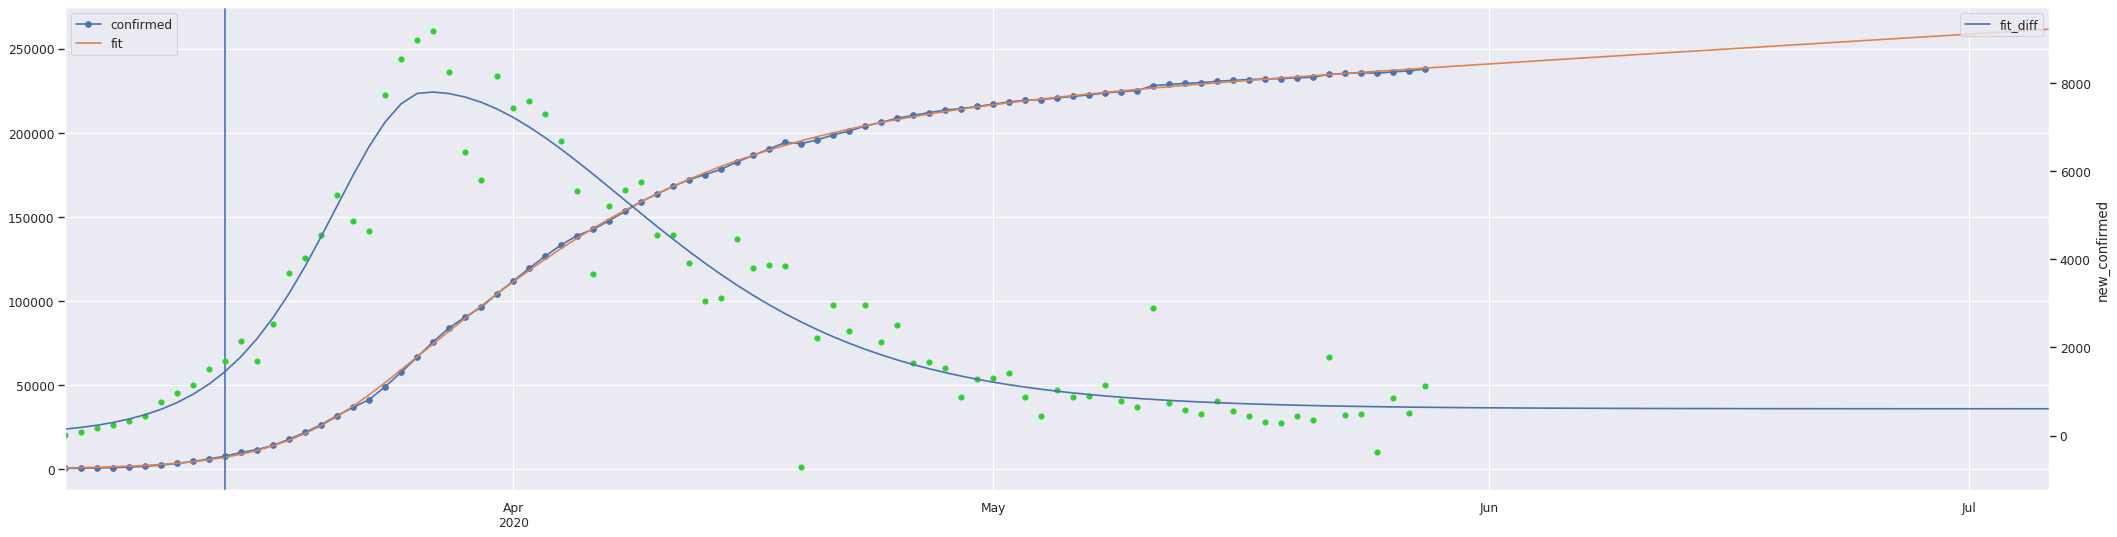

In [40]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 14))

In [41]:
cbr_spain.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,7791.566336


In [42]:
cbr_spain.calculate_R_estimates()
cbr_spain.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
index,,,,,
2020-05-26,0.929,0.91,1.619,1.127,0.989


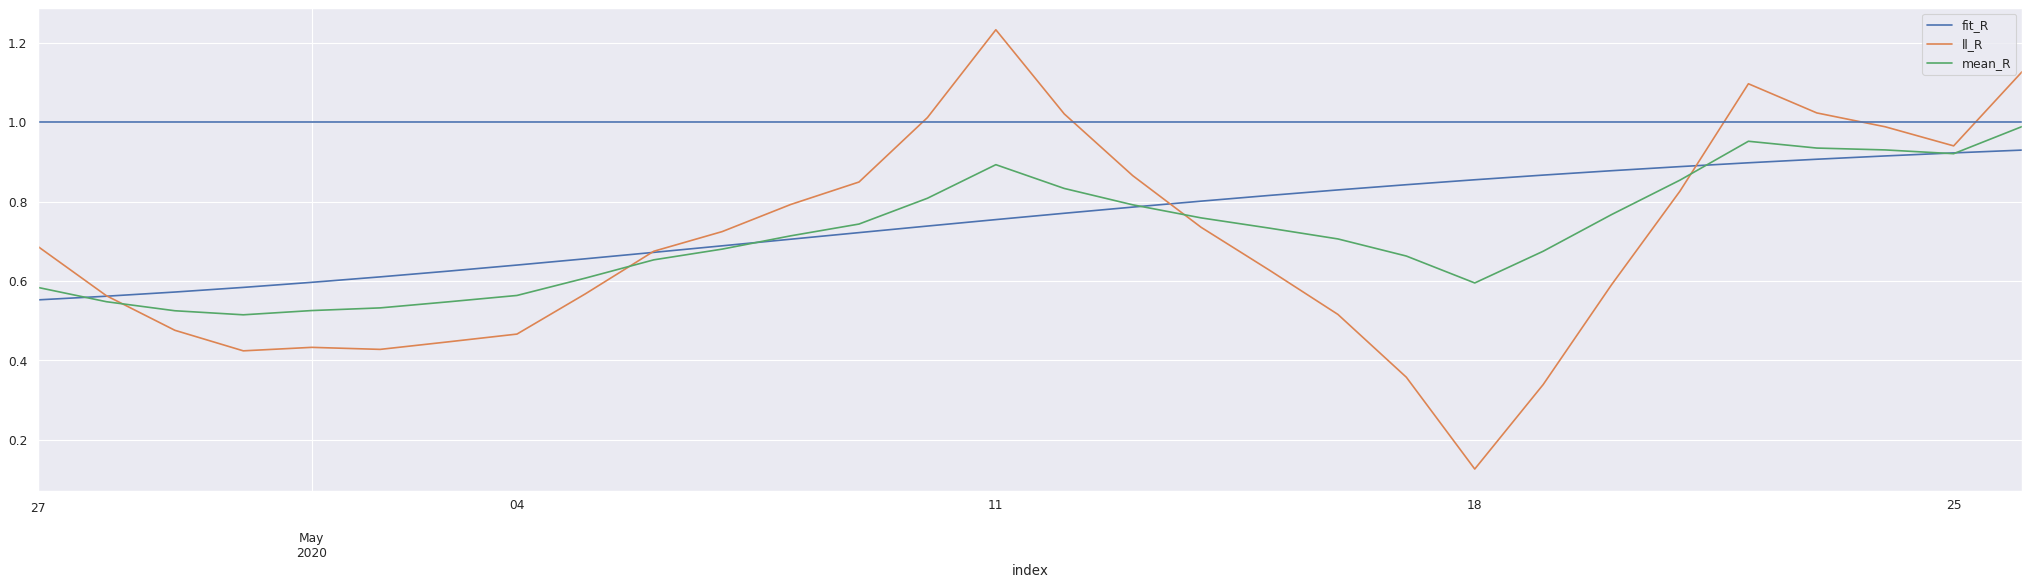

In [43]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_spain.plot_R(ax=ax) # , plot_start_date='2020-03-10'

* [Community Wiki: Resources on Data Science (and friends) vs. COVID-19](https://discourse.data-against-covid.org/t/community-wiki-resources-on-data-science-and-friends-vs-covid-19/731)
* [Number of deaths per age group per country?](https://discourse.data-against-covid.org/t/number-of-deaths-per-age-group-per-country/940)



* [opencovid19-fr / data](https://github.com/opencovid19-fr/data/blob/master/README.en.md)
    * [chiffres-cles.csv](https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv)
    * [dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/5e09dff7cb434fb194e22261689e2887)
    * [santepubliquefrance](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde)

In [44]:
df =covid19.get_france_df()
cbr_france = covid19.CasesByRegion('France', df=df)
cbr_france.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
date,,,,,,
2020-05-24,144921,64617,28367,115,70,35
2020-05-25,145279,65199,28457,358,582,90
2020-05-26,145555,65879,28530,276,680,73
2020-05-27,145746,66584,28596,191,705,66
2020-05-28,149071,67191,28662,3325,607,66


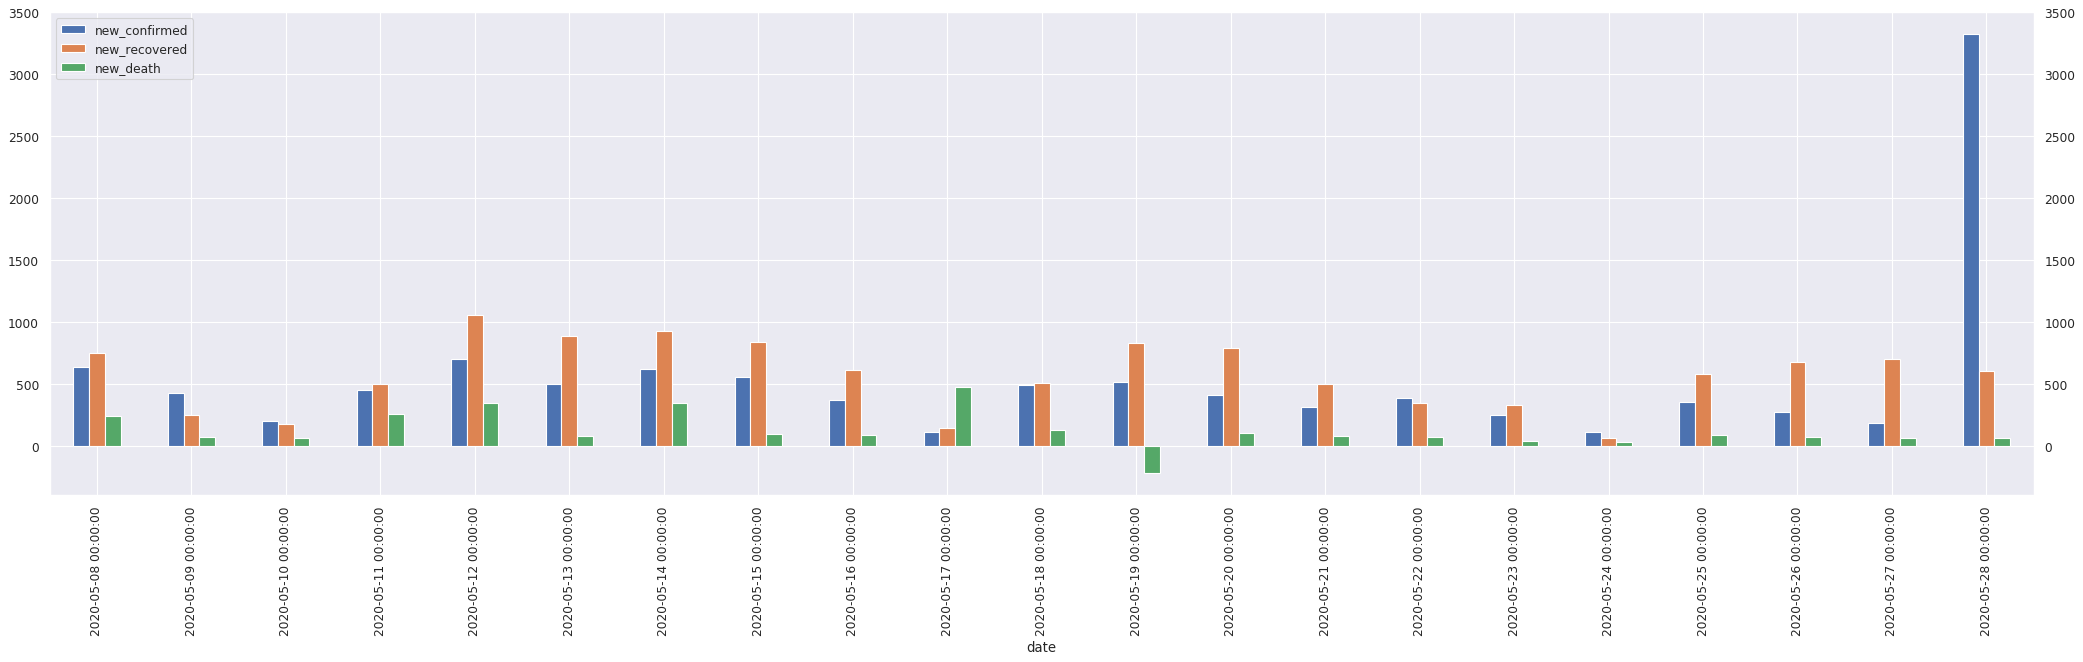

In [45]:
cbr_france.plot_daily_stats()

In [46]:
cbr_france.fit(first_date=pd.to_datetime('2020-03-04'))

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric+linear: seor: 968.3956215649637; growth-rate: 0.003, date:2020-07-06 00:00:00, projected value: 347.2984623194648


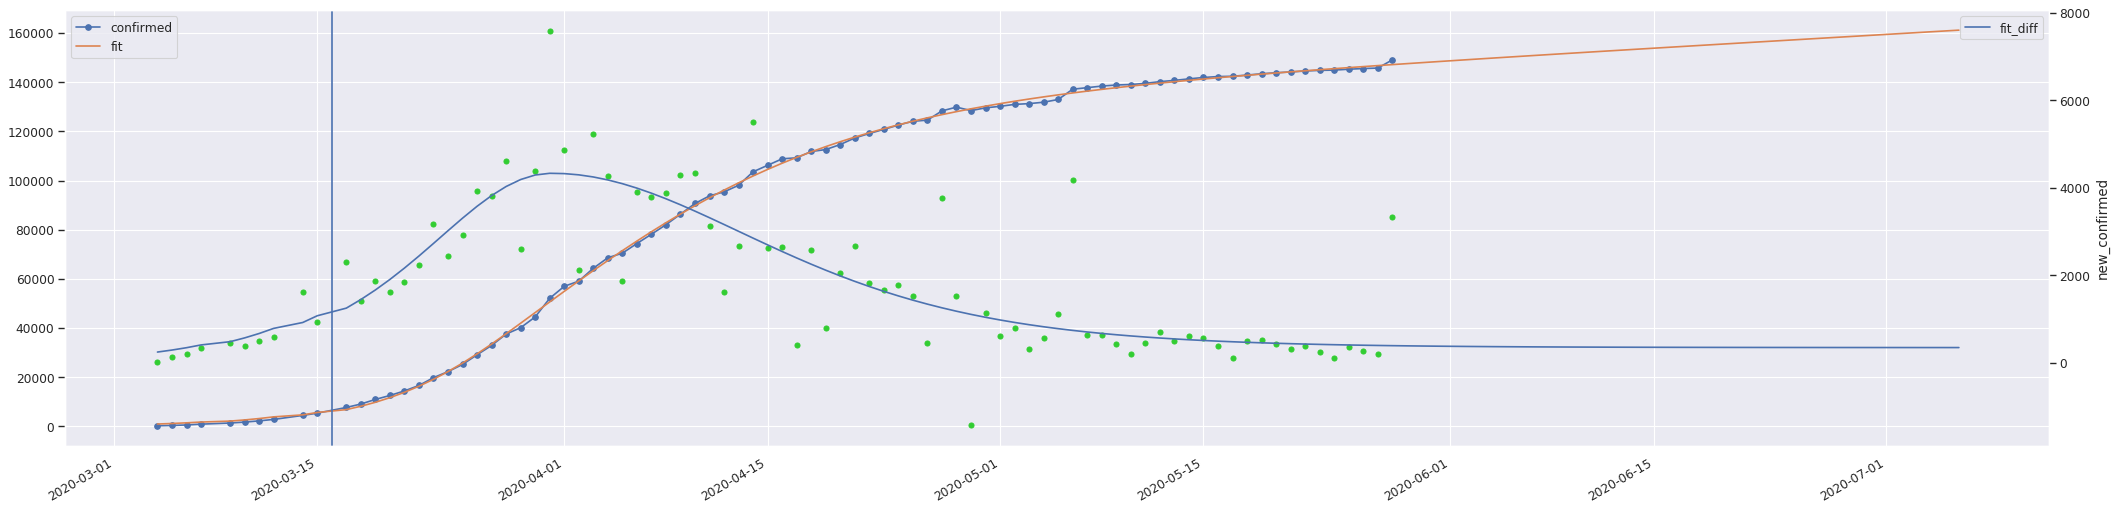

In [47]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_with_fits(ax=ax, restriction_start_date=datetime.datetime(2020, 3, 16))

In [48]:
cbr_france.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,4329.826232


In [49]:
cbr_france.calculate_R_estimates()
cbr_france.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
date,,,,,
2020-05-26,0.871,0.756,0.443,0.601,0.743


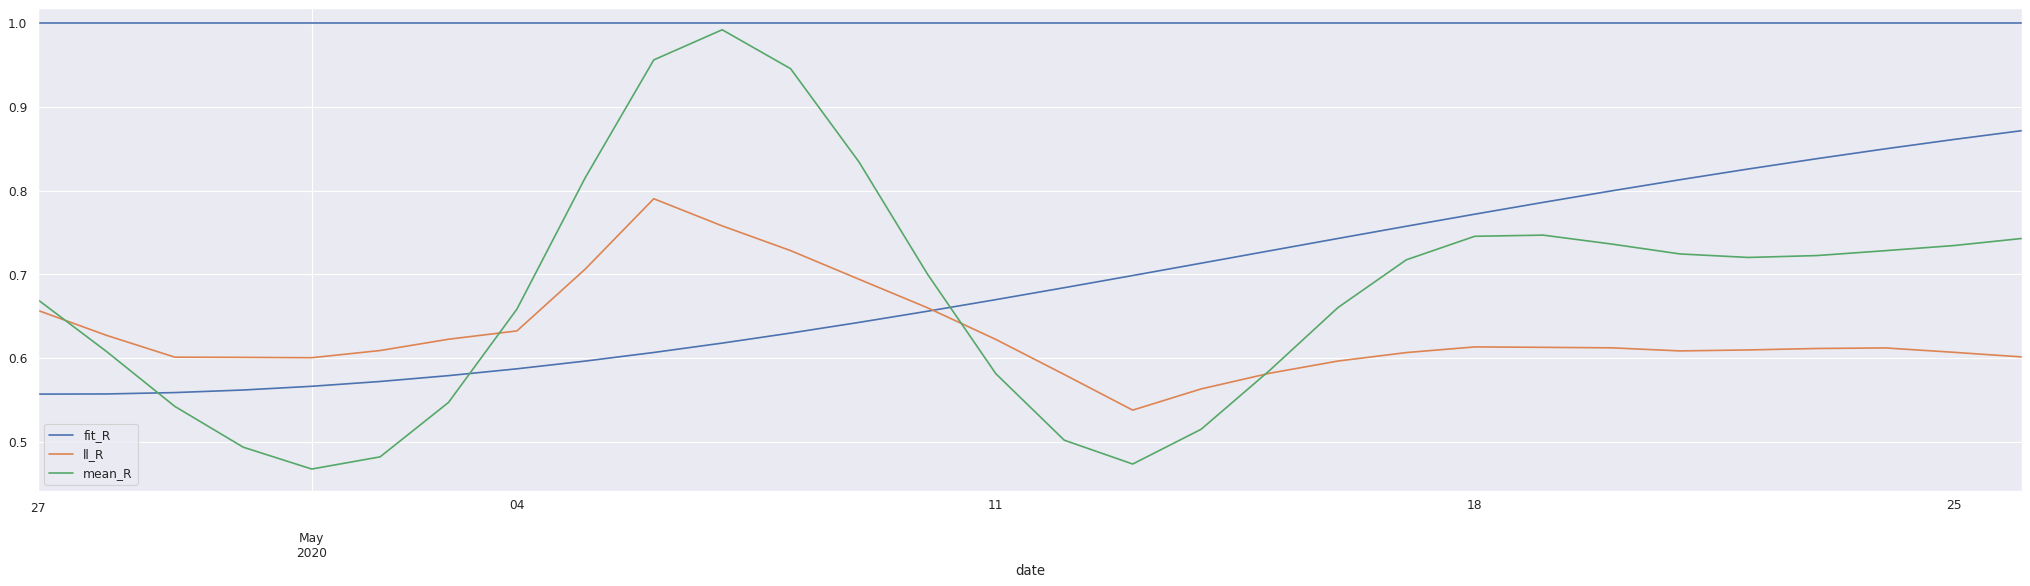

In [50]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_france.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [51]:
cbr_south_korea = covid19.CasesByRegion('Korea, South')
cbr_south_korea.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,11206,10226,267,16,13,1
2020-05-25,11225,10275,269,19,49,2
2020-05-26,11265,10295,269,40,20,0
2020-05-27,11344,10340,269,79,45,0
2020-05-28,11402,10363,269,58,23,0


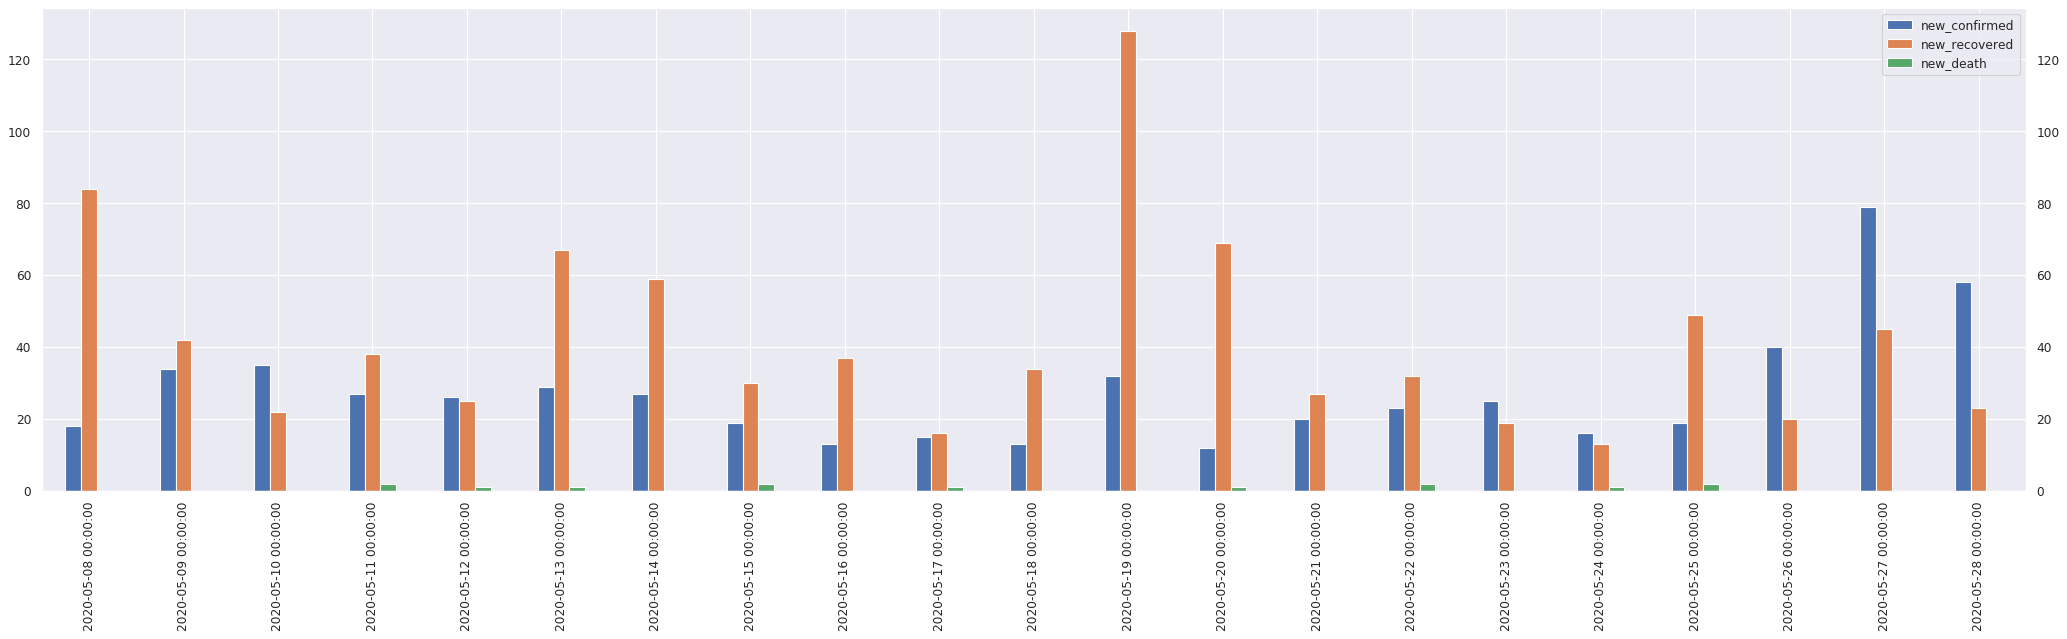

In [52]:
cbr_south_korea.plot_daily_stats()

In [53]:
cbr_uk = covid19.CasesByRegion('United Kingdom')
cbr_uk.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,260916,1151,36875,2412,2,118
2020-05-25,262547,1161,36996,1631,10,121
2020-05-26,266599,1161,37130,4052,0,134
2020-05-27,268619,1166,37542,2020,5,412
2020-05-28,270508,1167,37919,1889,1,377


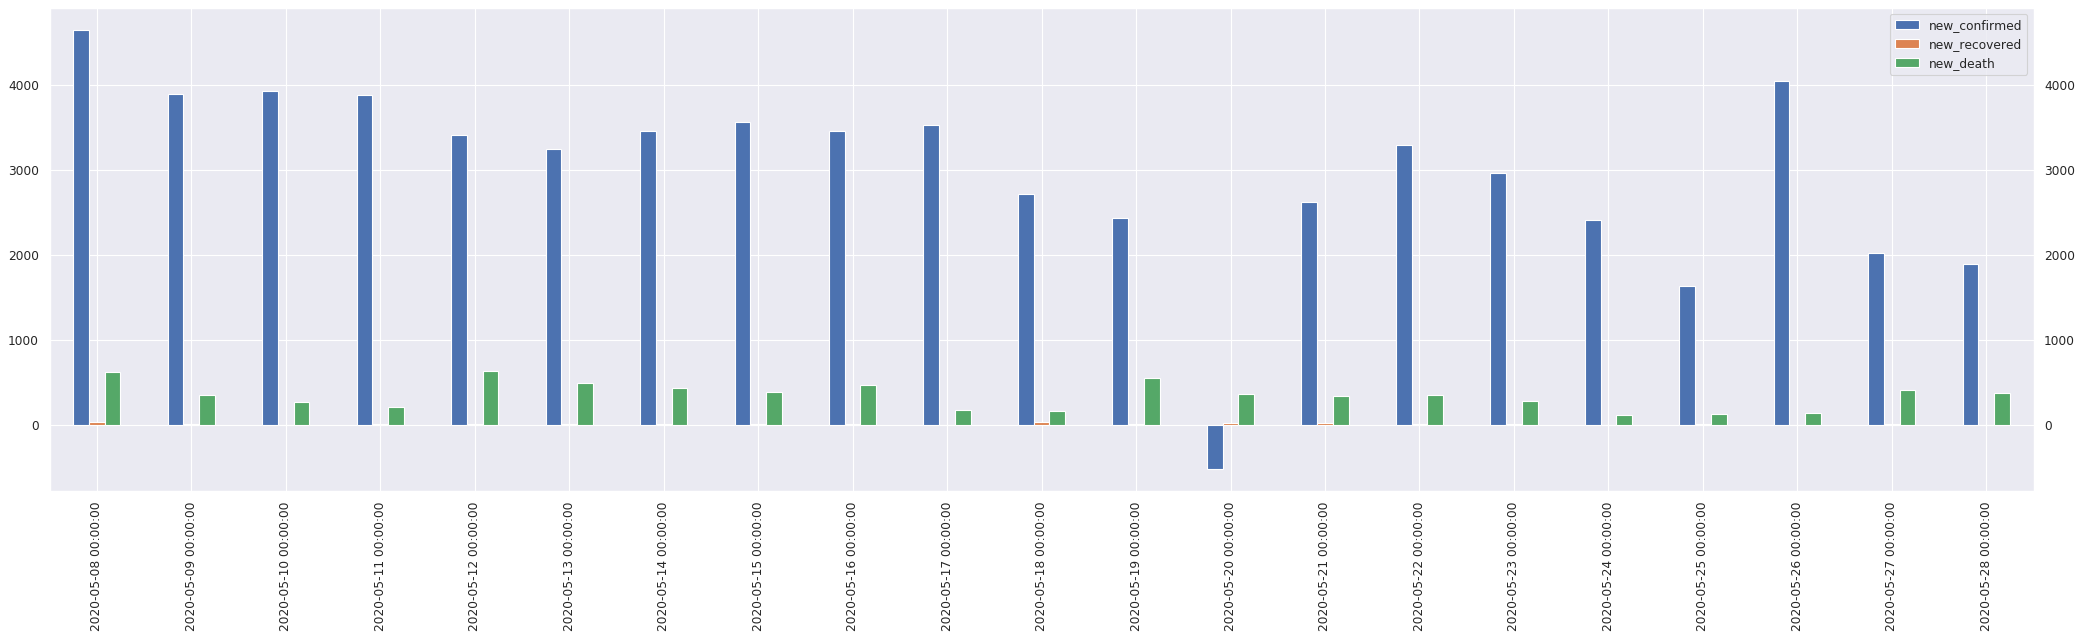

In [54]:
cbr_uk.plot_daily_stats()

In [55]:
cbr_uk.fit(first_date=pd.to_datetime('2020-03-05'))

sigmoid+asymmetric: seor: 829.8000991789154, max asymptotic: 346928.8968556831; growth-rate: 0.01, date:2020-07-06 00:00:00, projected value: 577.8251253554415


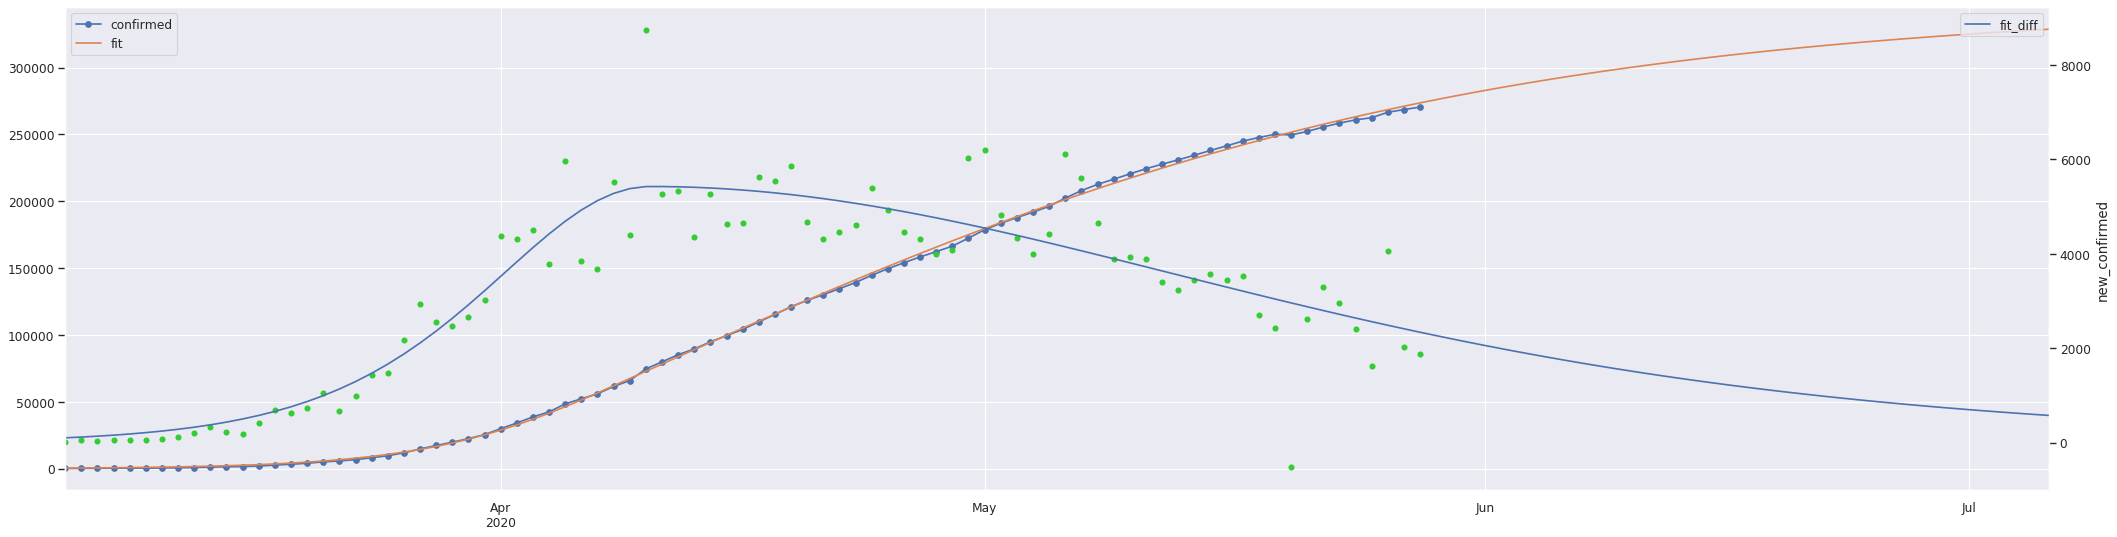

In [56]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_with_fits(ax=ax)

In [57]:
cbr_uk.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,5427.00677


In [58]:
cbr_uk.calculate_R_estimates()
cbr_uk.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-26,0.801,0.962,1.329,0.81,0.858


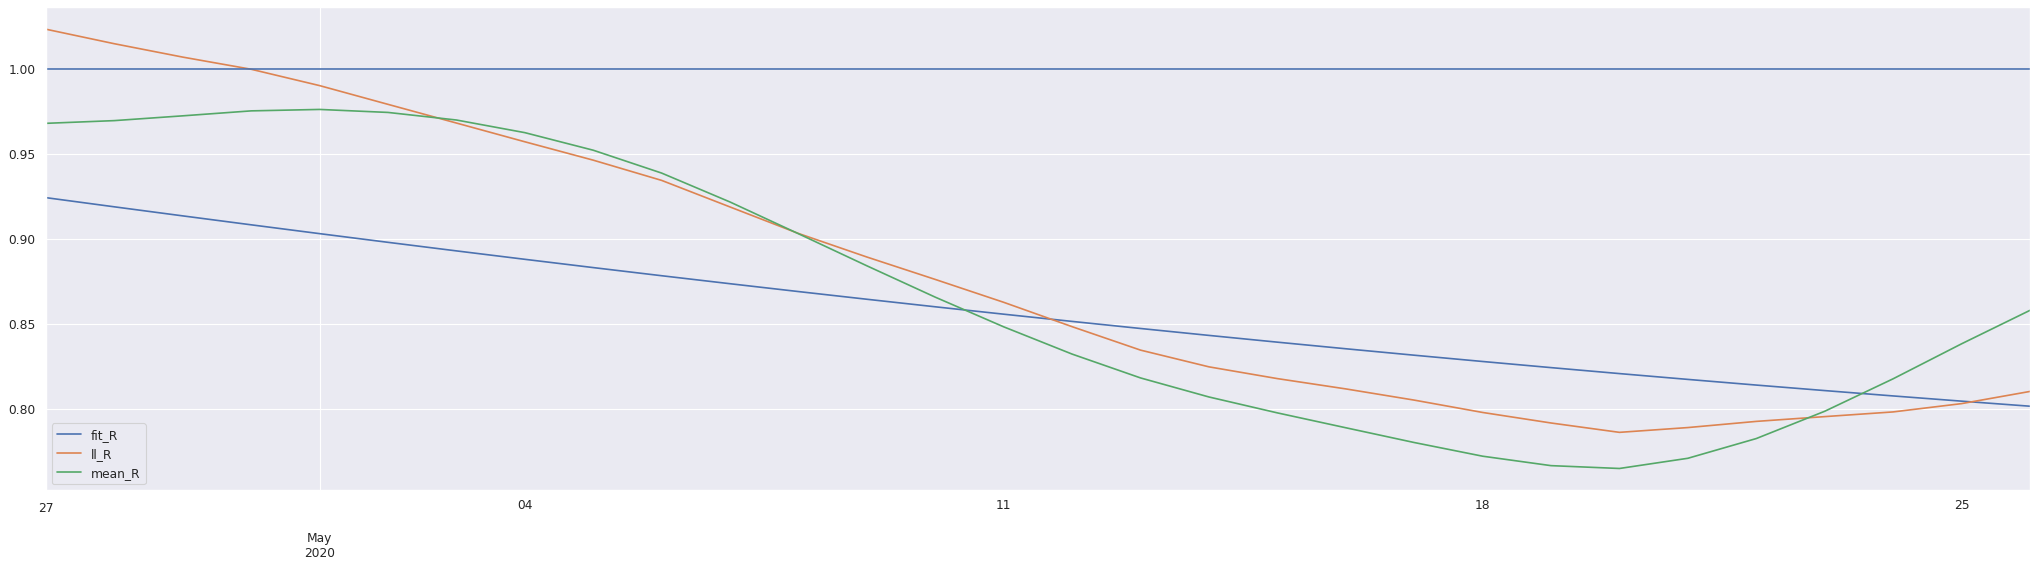

In [59]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_uk.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [60]:
cbr_us = covid19.CasesByRegion('US')
cbr_us.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,1643246,366736,97719,20634,5497,633
2020-05-25,1662302,379157,98219,19056,12421,500
2020-05-26,1680913,384902,98912,18611,5745,693
2020-05-27,1699176,391508,100417,18263,6606,1505
2020-05-28,1721753,399991,101616,22577,8483,1199


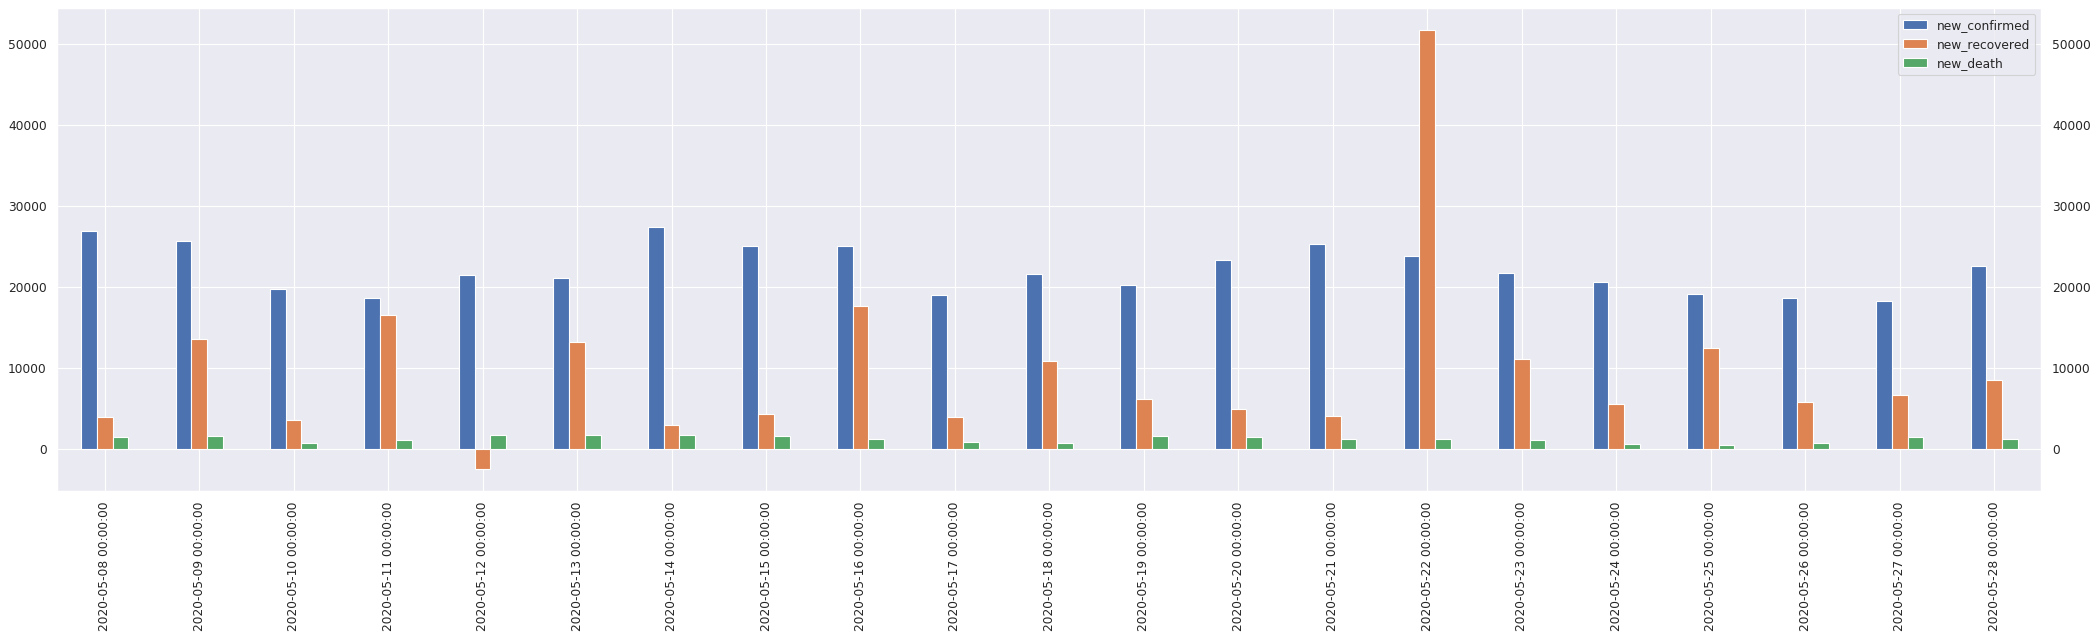

In [61]:
cbr_us.plot_daily_stats()

In [62]:
cbr_us.fit(first_date=pd.to_datetime('2020-03-11'))

sigmoid+asymmetric: seor: 2676.317746404923, max asymptotic: 2604201.04731263; growth-rate: 0.012, date:2020-07-06 00:00:00, projected value: 8862.771906693193


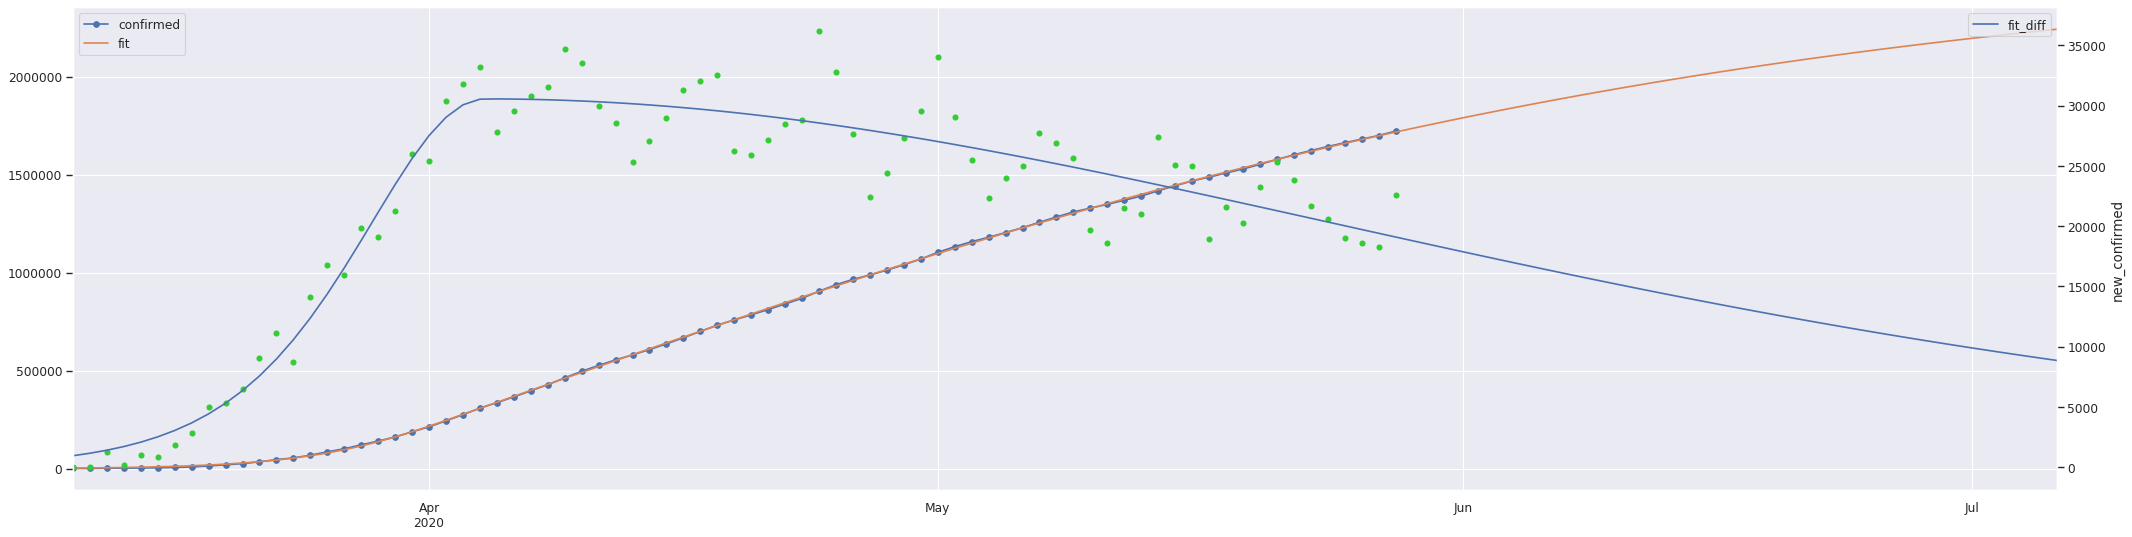

In [63]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_with_fits(ax=ax)

In [64]:
cbr_us.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,30556.533213


In [65]:
cbr_us.calculate_R_estimates()
cbr_us.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-26,0.896,0.978,0.925,0.966,0.947


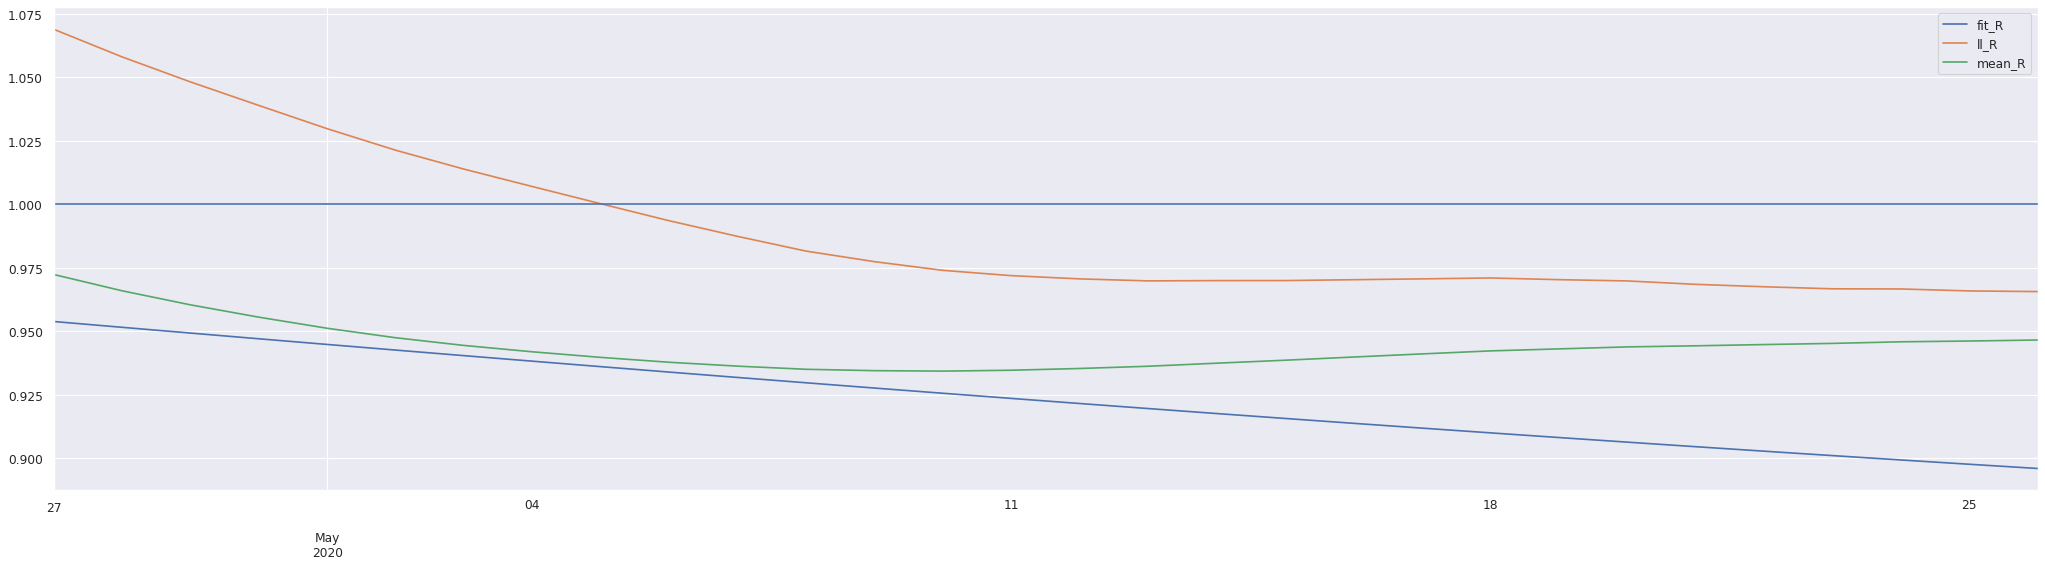

In [66]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_us.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [67]:
cbr_switzerland = covid19.CasesByRegion('Switzerland')
cbr_switzerland.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,30736,28100,1906,11,100,1
2020-05-25,30746,28200,1913,10,100,7
2020-05-26,30761,28200,1915,15,0,2
2020-05-27,30776,28300,1917,15,100,2
2020-05-28,30796,28300,1919,20,0,2


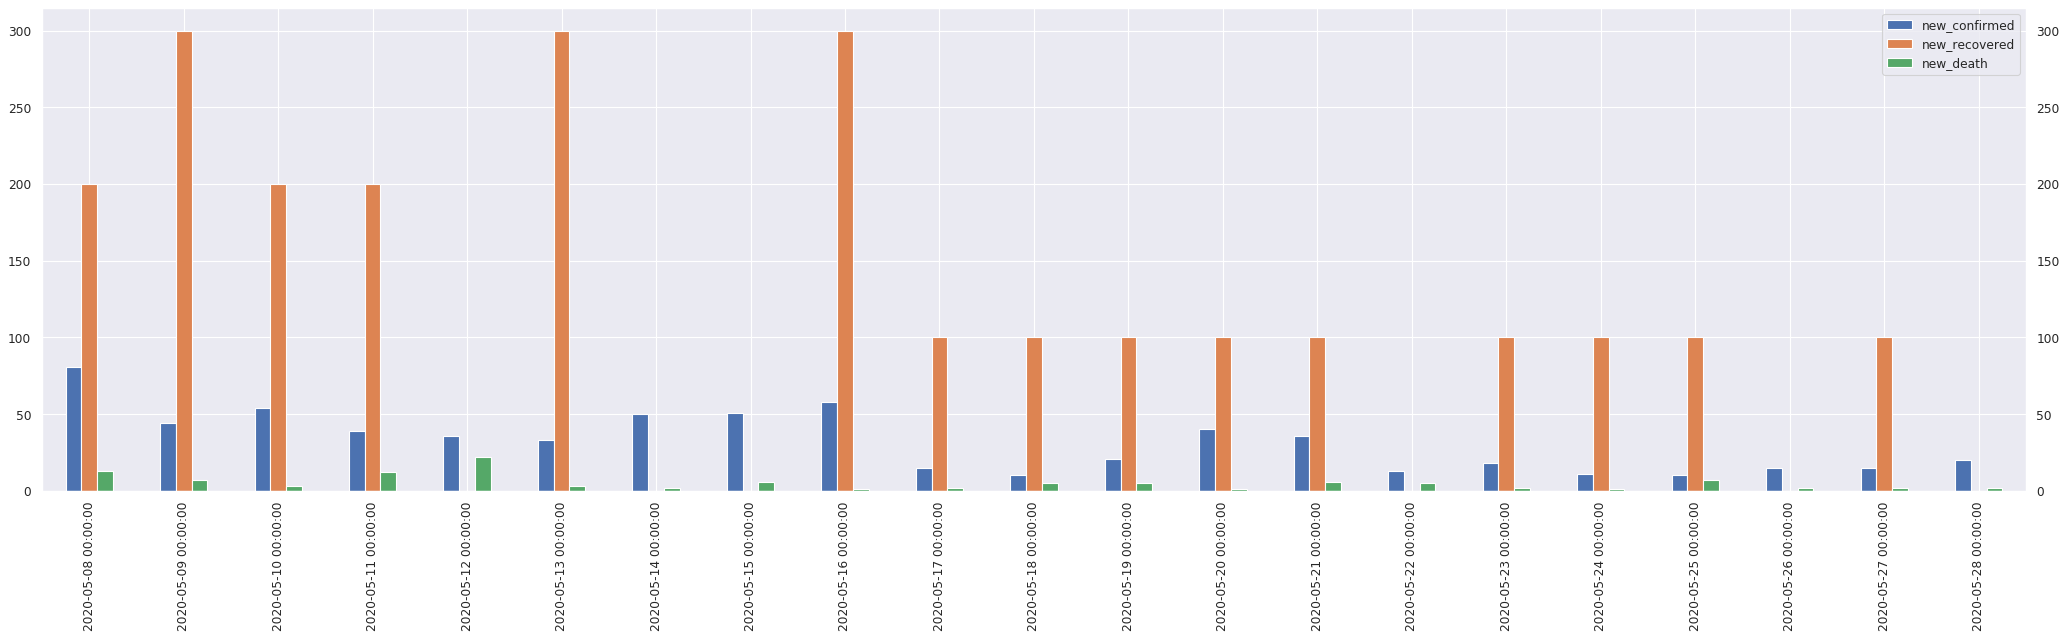

In [68]:
cbr_switzerland.plot_daily_stats()

In [69]:
cbr_switzerland.fit(first_date=pd.to_datetime('2020-03-05'), new_confirmed_threshold=1)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None
 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:Covariance of the parameters could not be estimated


sigmoid+asymmetric: seor: 140.95589051748829, max asymptotic: 30741.001922194442; growth-rate: 0.0, date:2020-06-21 00:00:00, projected value: 0.8970327960474553


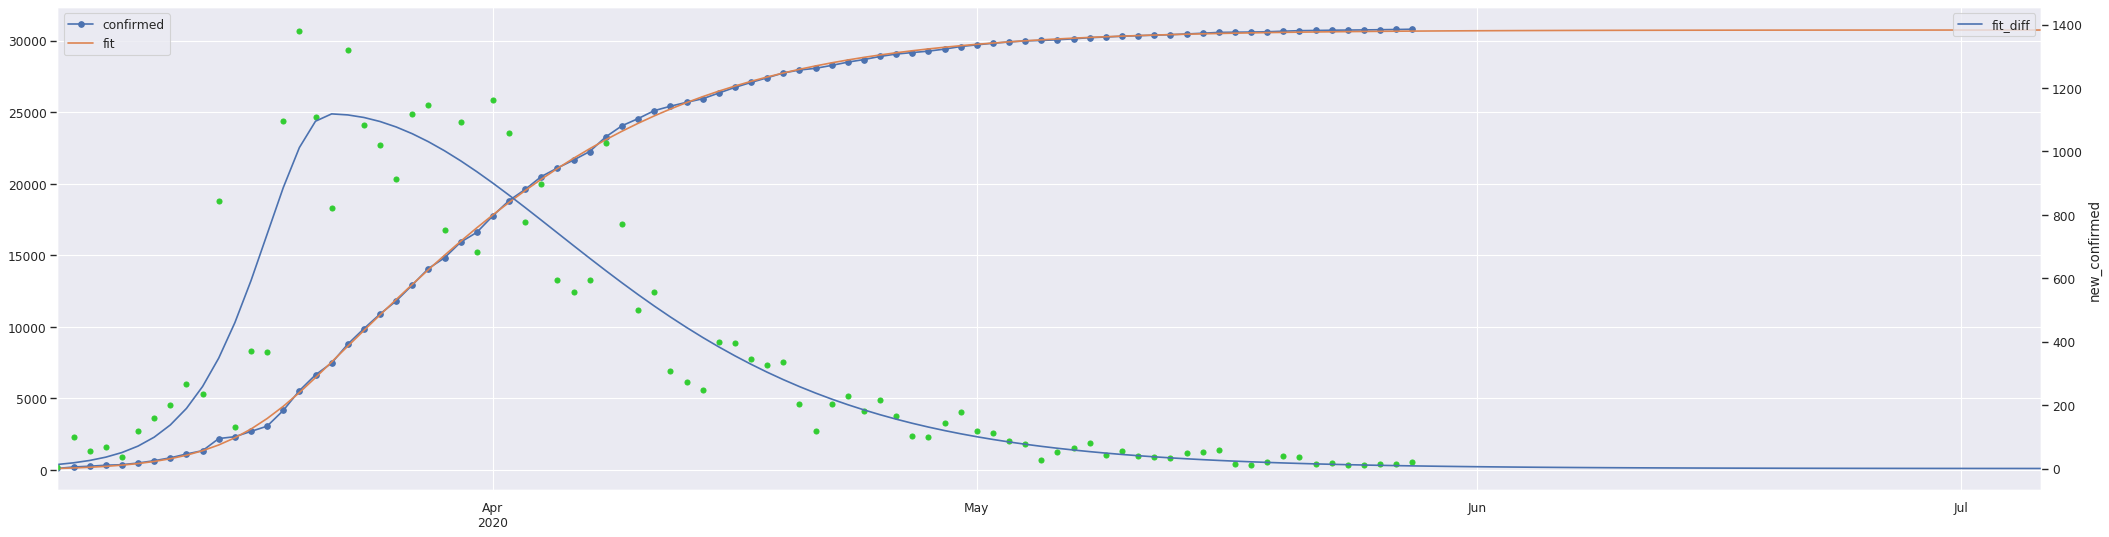

In [70]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_with_fits(ax=ax)

In [71]:
cbr_switzerland.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,1118.610844


In [72]:
cbr_switzerland.calculate_R_estimates()
cbr_switzerland.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:No frequency information was provided, so inferred frequency D will be used.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-26,0.38,0.589,0.771,0.532,0.5


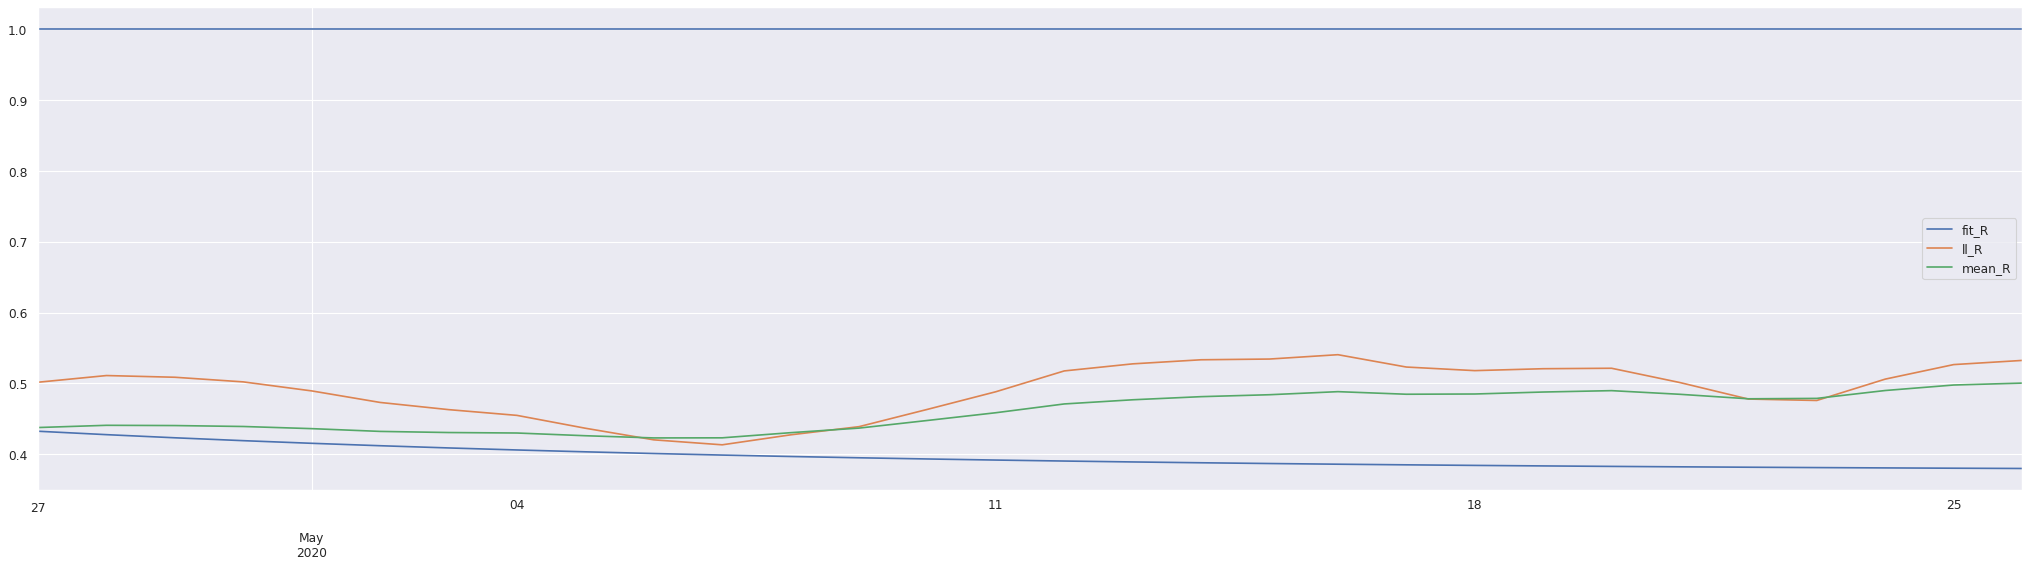

In [73]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_switzerland.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [74]:
cbr_australia = covid19.CasesByRegion('Australia')
cbr_australia.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-05-24,7114,6531,102,0,23,0
2020-05-25,7126,6552,102,12,21,0
2020-05-26,7139,6560,103,13,8,1
2020-05-27,7150,6579,103,11,19,0
2020-05-28,7165,6576,103,15,-3,0


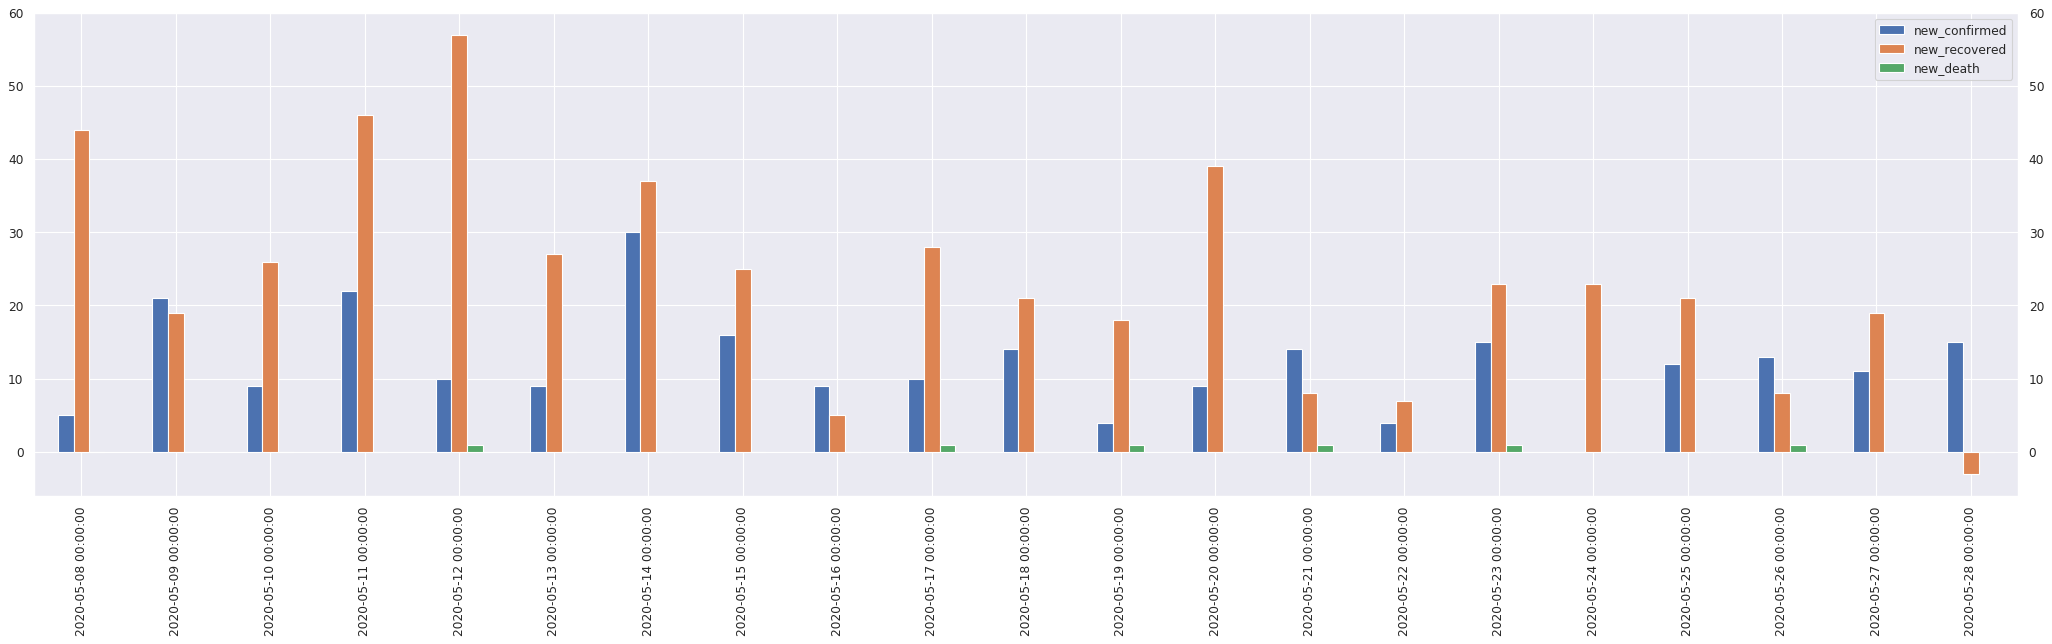

In [75]:
cbr_australia.plot_daily_stats()

In [76]:
cbr_australia.fit(first_date=pd.to_datetime('2020-03-10'), new_confirmed_threshold=2.0)

 /home/local/cs/workspaces/covid-19-data-analysis/covid19.py:1526: UserWarning:Exception in curve_fit: Optimal parameters not found: Number of calls to function has reached maxfev = 600./ None


sigmoid+asymmetric+linear: seor: 43.4451630830699; growth-rate: 0.002, date:2020-07-06 00:00:00, projected value: 15.449931862483488


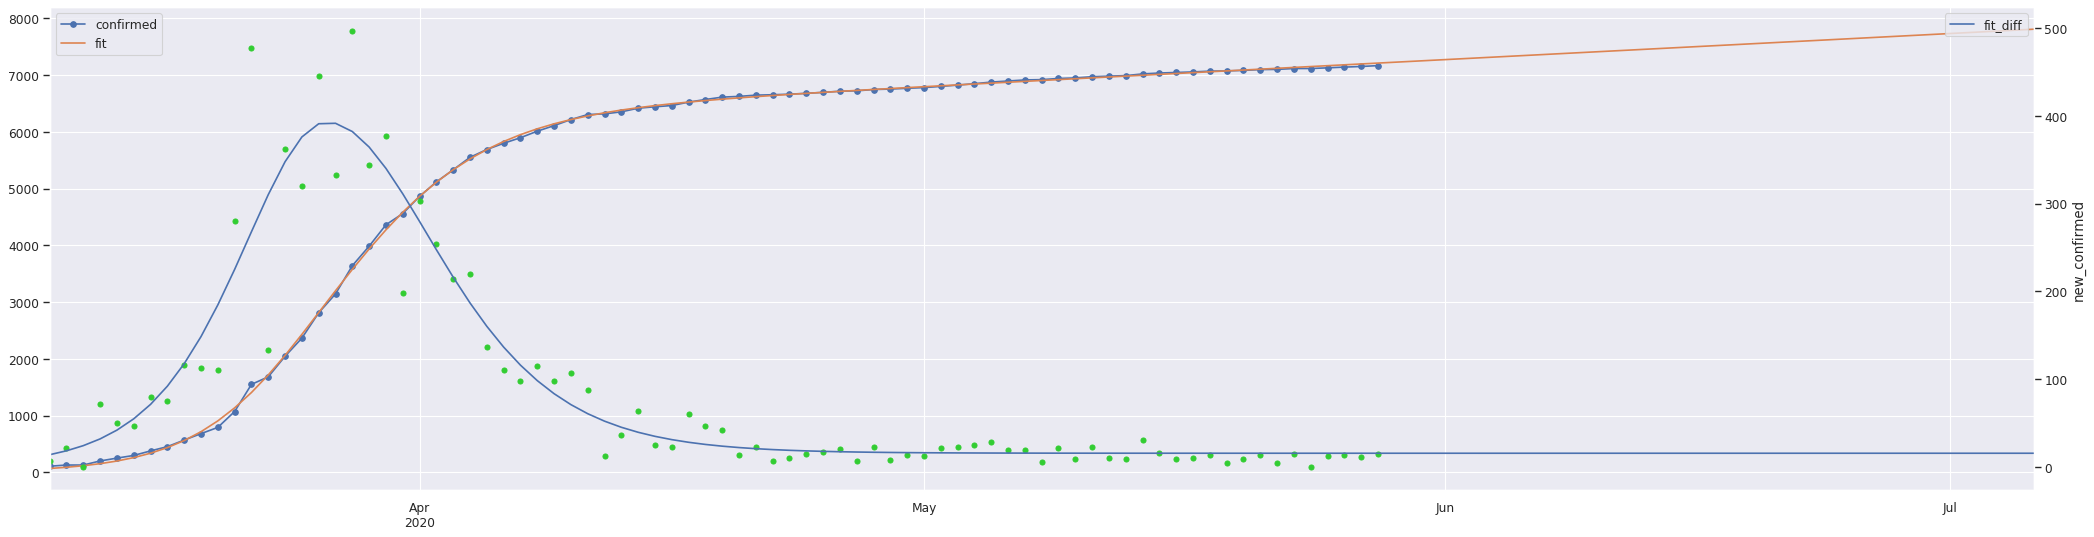

In [77]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_with_fits(ax=ax)

In [78]:
cbr_australia.fit_df0[['fit_diff']].apply(['max'])

,fit_diff
max,391.656891


In [79]:
cbr_australia.calculate_R_estimates()
cbr_australia.R().round(3)

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


,fit_R,gp_R,kf_R,ll_R,mean_R
2020-05-26,0.999,0.856,1.644,0.916,0.924


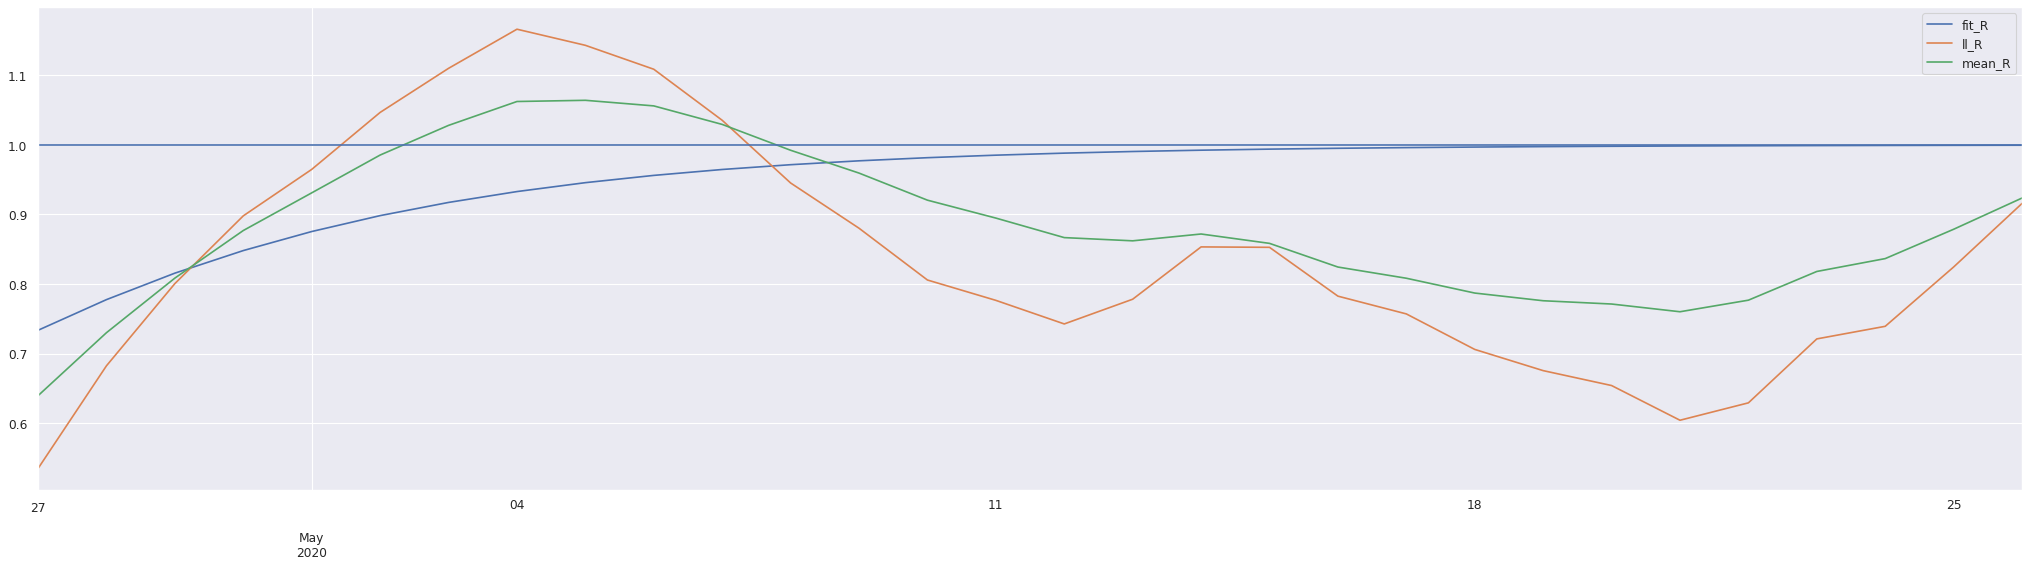

In [80]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
cbr_australia.plot_R(ax=ax) # , plot_start_date='2020-03-10'

In [81]:
df_co = covid19.get_country_overview()
df_co.head()

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-28,,,,,
MS Zaandam,9,0,2,22.222222,66.666667
Yemen,278,11,57,20.503597,82.608696
Belgium,57849,15572,9388,16.228457,37.610673
France,186364,67309,28665,15.381190,29.867153
Italy,231732,150604,33142,14.301866,18.036757


In [82]:
df_co[df_co.confirmed > 10000].round(1)

,confirmed,recovered,death,death_rate,death_rate_
Country/Region_2020-05-28,,,,,
Belgium,57849,15572,9388,16.2,37.6
France,186364,67309,28665,15.4,29.9
Italy,231732,150604,33142,14.3,18.0
United Kingdom,270508,1167,37919,14.0,97.0
Netherlands,46152,178,5922,12.8,97.1
Sweden,35727,4971,4266,11.9,46.2
Spain,237906,150376,27119,11.4,15.3
Mexico,81400,56041,9044,11.1,13.9
Ecuador,38471,18425,3313,8.6,15.2
